# CS-401: Milestone P2

This notebook aims to provide a basic primary pre-processing and analysis of datasets that we will be using. The pre-processing pipeline is divided into three parts: loading, cleaning and merging. One can have a look of this pipeline in the `preprocessing` folder. For more information, look at the `README`.

**Content of this notebook**
- [Data Processing](#preprocessing)
  - [Loading datasets](#1-load-the-data)
  - [Cleaning](#2-basic-cleaning)
  - [Merging](#3-merging-all-datasets)
- [Basic Statistical Analysis](#exploratory--basic-analysis)
  - [Handling Outlier](#1-outliers-removal)
  - [Missing values analysis](#2-missing-values-analysis)
  - [Key features' distribution](#3-distribution-of-key-features)
  - [Rating vs Number of actress](#4-is-there-a-link-between-popularity-and-proportion-of-women-in-a-movie)
  - [Age analysis](#5-is-there-a-difference-in-age-for-women)
  - [Bechdel Test](#6-bechdel-test)
- [Basic NLP on Summaries](#nlp-on-plot-summaries)
  - [Preprocessing and Tokenization](#1-preprocessing-of-the-texts-and-cleaning)
  - [Feminity Score](#2-feminity-score-analysis)


---

In [1]:
import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")
sys.path.append("./nlp")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Our tools (see python files in preprocessing and analysis)
import loader
import cleaner
import merger
import visualizer as viz
import nlp_utils as nlputils

%load_ext autoreload
%autoreload 2

# Preprocessing

## 1. Load the data

We first start by loading datasets. CMU dataset is loaded as well as external dataset like Bechdel and TMDB dataset since these will be useful later for a more in-depth analysis.

In [2]:
# =============== LOADER =============== #
# CMU Dataset
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# External Dataset
bechdel_df = loader.load_bechdel_dataset()
credits_df, meta_df = loader.load_tmdb_dataset()

## 2. Basic cleaning

Here, we perform basic data cleaning operations on dataframes, such as renaming columns and converting date strings into Python datetime objects. To handle the credits dataframe, you can refer to the [clean_credit_df function](./preprocessing/cleaner.py#clean_credit_df). Our objective is to analyze women's representation in the film industry, and to do this, we require information about the gender of the crew members for movies. We observed that this information was frequently missing, while full names were always provided. As a solution, we utilized the `genderguesser` package to predict the gender based on the first name. This approach allows us to reduce the number of ungendered samples without discarding entire rows.

In [3]:
# =============== CLEAN =============== #
# Clean datasets
movie_df = cleaner.clean_movie_df(movie_df)
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)
credits_df = cleaner.clean_credit_df(credits_df, meta_df)
meta_df = cleaner.clean_metadata_df(meta_df)

Before using genderguesser:
Percentage of movies with a director's name that could not be gendered: 39.44%
Percentage of movies with a producer's name that could not be gendered: 70.92%
Percentage of movies with a writer's name that could not be gendered:   77.54%

After using genderguesser:
Percentage of movies with a director's name that could not be gendered: 6.55%
Percentage of movies with a producer's name that could not be gendered: 54.08%
Percentage of movies with a writer's name that could not be gendered:   57.74%


## 3. Merging all datasets

In this step, we combine all our datasets to create a final dataset named `movies`, which will contain all the necessary features for our analysis.

In [4]:
# =============== MERGE =============== #
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Put the actor_name column at the beginning since we have one row per actor name
movies = movies.reindex(
    columns=["actor_name"] + [col for col in movies.columns if col != "actor_name"]
)
display(movies.sample(5))

# It will be useful when we will analyze the effect of the bechdel score rating on
# the women's representation in movies
movies_with_bechdel = merger.merge_with_bechdel(movies, bechdel_df)

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender,writer,writer_gender
99365,Saeed Jaffrey,1428955,/m/050t99,My Beautiful Laundrette,1985-09-07,2451545.0,97.0,"[Urdu Language, English Language]","[England, United Kingdom]","[LGBT, Indie, Comedy-drama, Gay, Gay Interest,...",...,2.793003,6.6,0091578,11240,Stephen Frears,M,Tim Bevan,M,NaN,NaN
75215,Koreya Senda,5499192,/m/0dpl6c,The H-Man,1958-06-24,NaN,79.0,"[Japanese Language, English Language]",[Japan],"[Science Fiction, Japanese Movies, World cinema]",...,0.268765,6.3,0051413,43113,Malcolm D. Lee,M,NaN,NaN,David Zucker,M
48548,Nedra Volz,23464956,/m/06wb5f9,Little Miss Marker,1980-03-21,NaN,102.0,[English Language],[United States of America],"[Family Drama, Drama, Comedy, Romantic drama, ...",...,1.014961,6.0,0081063,47876,Walter Bernstein,M,Jennings Lang,M,NaN,NaN
36481,Michael Richards,1812216,/m/05yxmk,Coneheads,1993-07-23,21274717.0,86.0,[English Language],[United States of America],"[Parody, Science Fiction, Comedy]",...,10.722729,4.8,0106598,9612,Steve Barron,M,Lorne Michaels,M,NaN,NaN
134320,David Oyelowo,29454281,/m/0ds3t5x,The Help,2011-08-10,211608112.0,145.0,[English Language],"[United States of America, United Arab Emirate...","[Drama, Period piece, Comedy-drama]",...,7.486118,7.9,1454029,50014,Tate Taylor,M,Chris Columbus,M,NaN,NaN


In [5]:
# Alternatively:
# You can directly load full cleaned and merged data
# movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")

---

# Exploratory & Basic Analysis

Now, let's explore and try to understand the data. 

## 1. Outliers removal

In [6]:
movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,8.174700e+04,167861.000000,170127.000000,77404.000000,125455.000000,170127.000000
mean,7.591529e+07,105.253108,1988.899410,1.785753,38.336384,6.029420
std,1.491195e+08,26.051526,21.754745,3.765668,14.353359,1.220987
min,1.047400e+04,0.566667,1893.000000,0.610000,-81.000000,0.000000
25%,5.781045e+06,91.000000,1977.000000,1.680000,28.000000,5.500000
50%,2.257359e+07,101.000000,1997.000000,1.760000,37.000000,6.200000
75%,7.837120e+07,115.000000,2006.000000,1.830000,47.000000,6.800000
max,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000


As one can see, there are outliers and dirty samples in the data: negative actor's ages, movies of 16h long, ... 
We will remove them in the next cell, outliers will be remove by quantile method (see [here](./preprocessing/cleaner.py#clean_remove_outlier))

In [7]:
movies = cleaner.clean_movies_ranges(movies)
movies = cleaner.clean_remove_outlier(
    movies, method="quantile", name="actor_height_meters"
)
movies = cleaner.clean_remove_outlier(movies, method="quantile", name="movie_runtime")

movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,4.254300e+04,71601.000000,71601.000000,71601.000000,67696.000000,71601.000000
mean,7.767795e+07,103.272821,1991.414394,1.756210,37.778658,5.959284
std,1.334172e+08,15.544283,19.578993,0.100157,13.744698,1.133186
min,1.263600e+04,60.000000,1914.000000,1.470000,0.000000,0.000000
25%,7.175592e+06,92.000000,1984.000000,1.680000,28.000000,5.500000
50%,2.696019e+07,101.000000,1998.000000,1.760000,36.000000,6.100000
75%,8.832349e+07,113.000000,2006.000000,1.830000,46.000000,6.700000
max,1.511758e+09,148.000000,2012.000000,2.050000,95.000000,10.000000


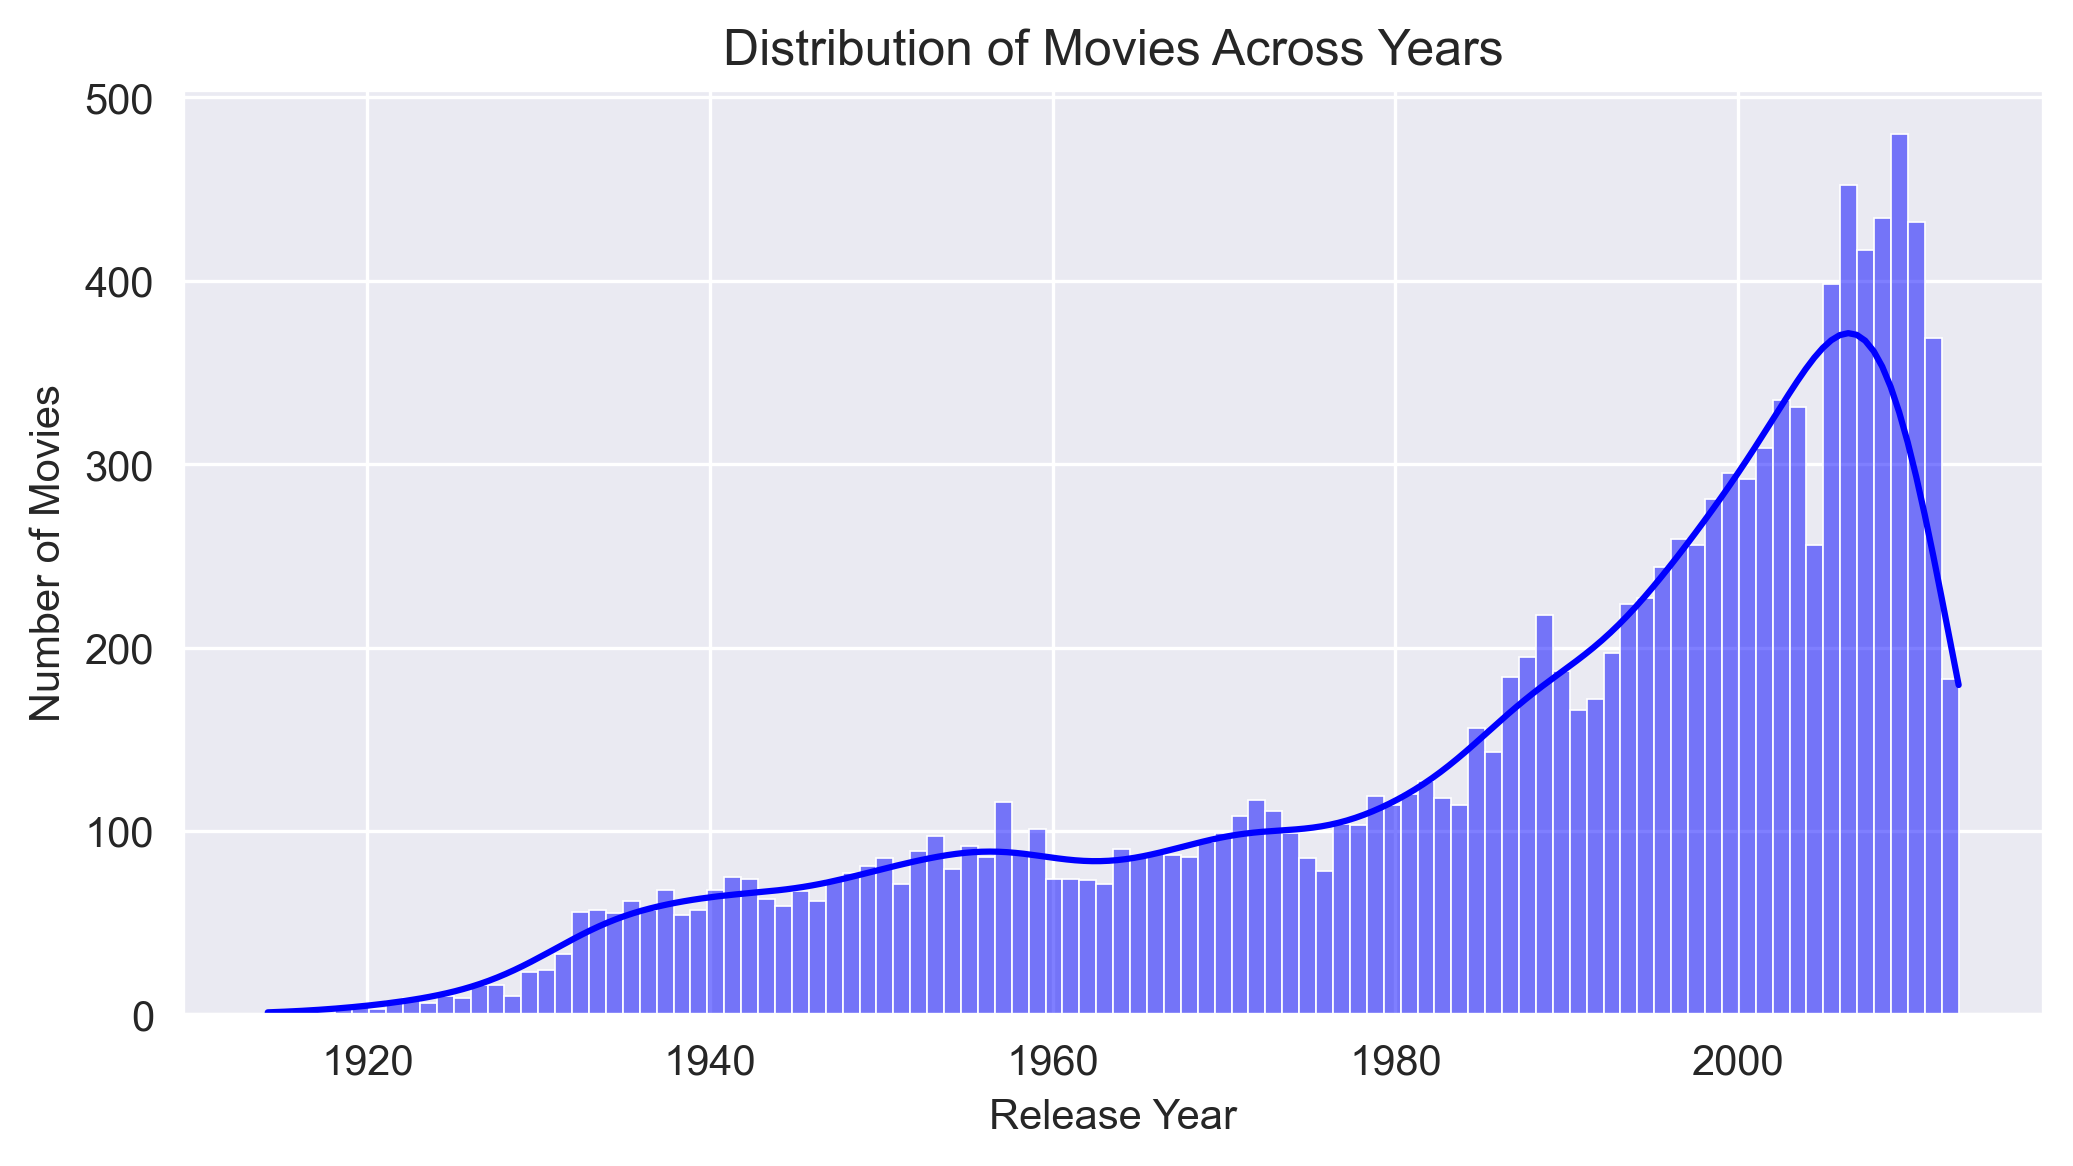

Total number of movies:  12779
Mean number of movies per year: 132


In [8]:
viz.visualize_year_distribution(movies)

With this cleaning, we are sure to have at least around 50 movies per year, from year 1935. 

## 2. Missing values analysis

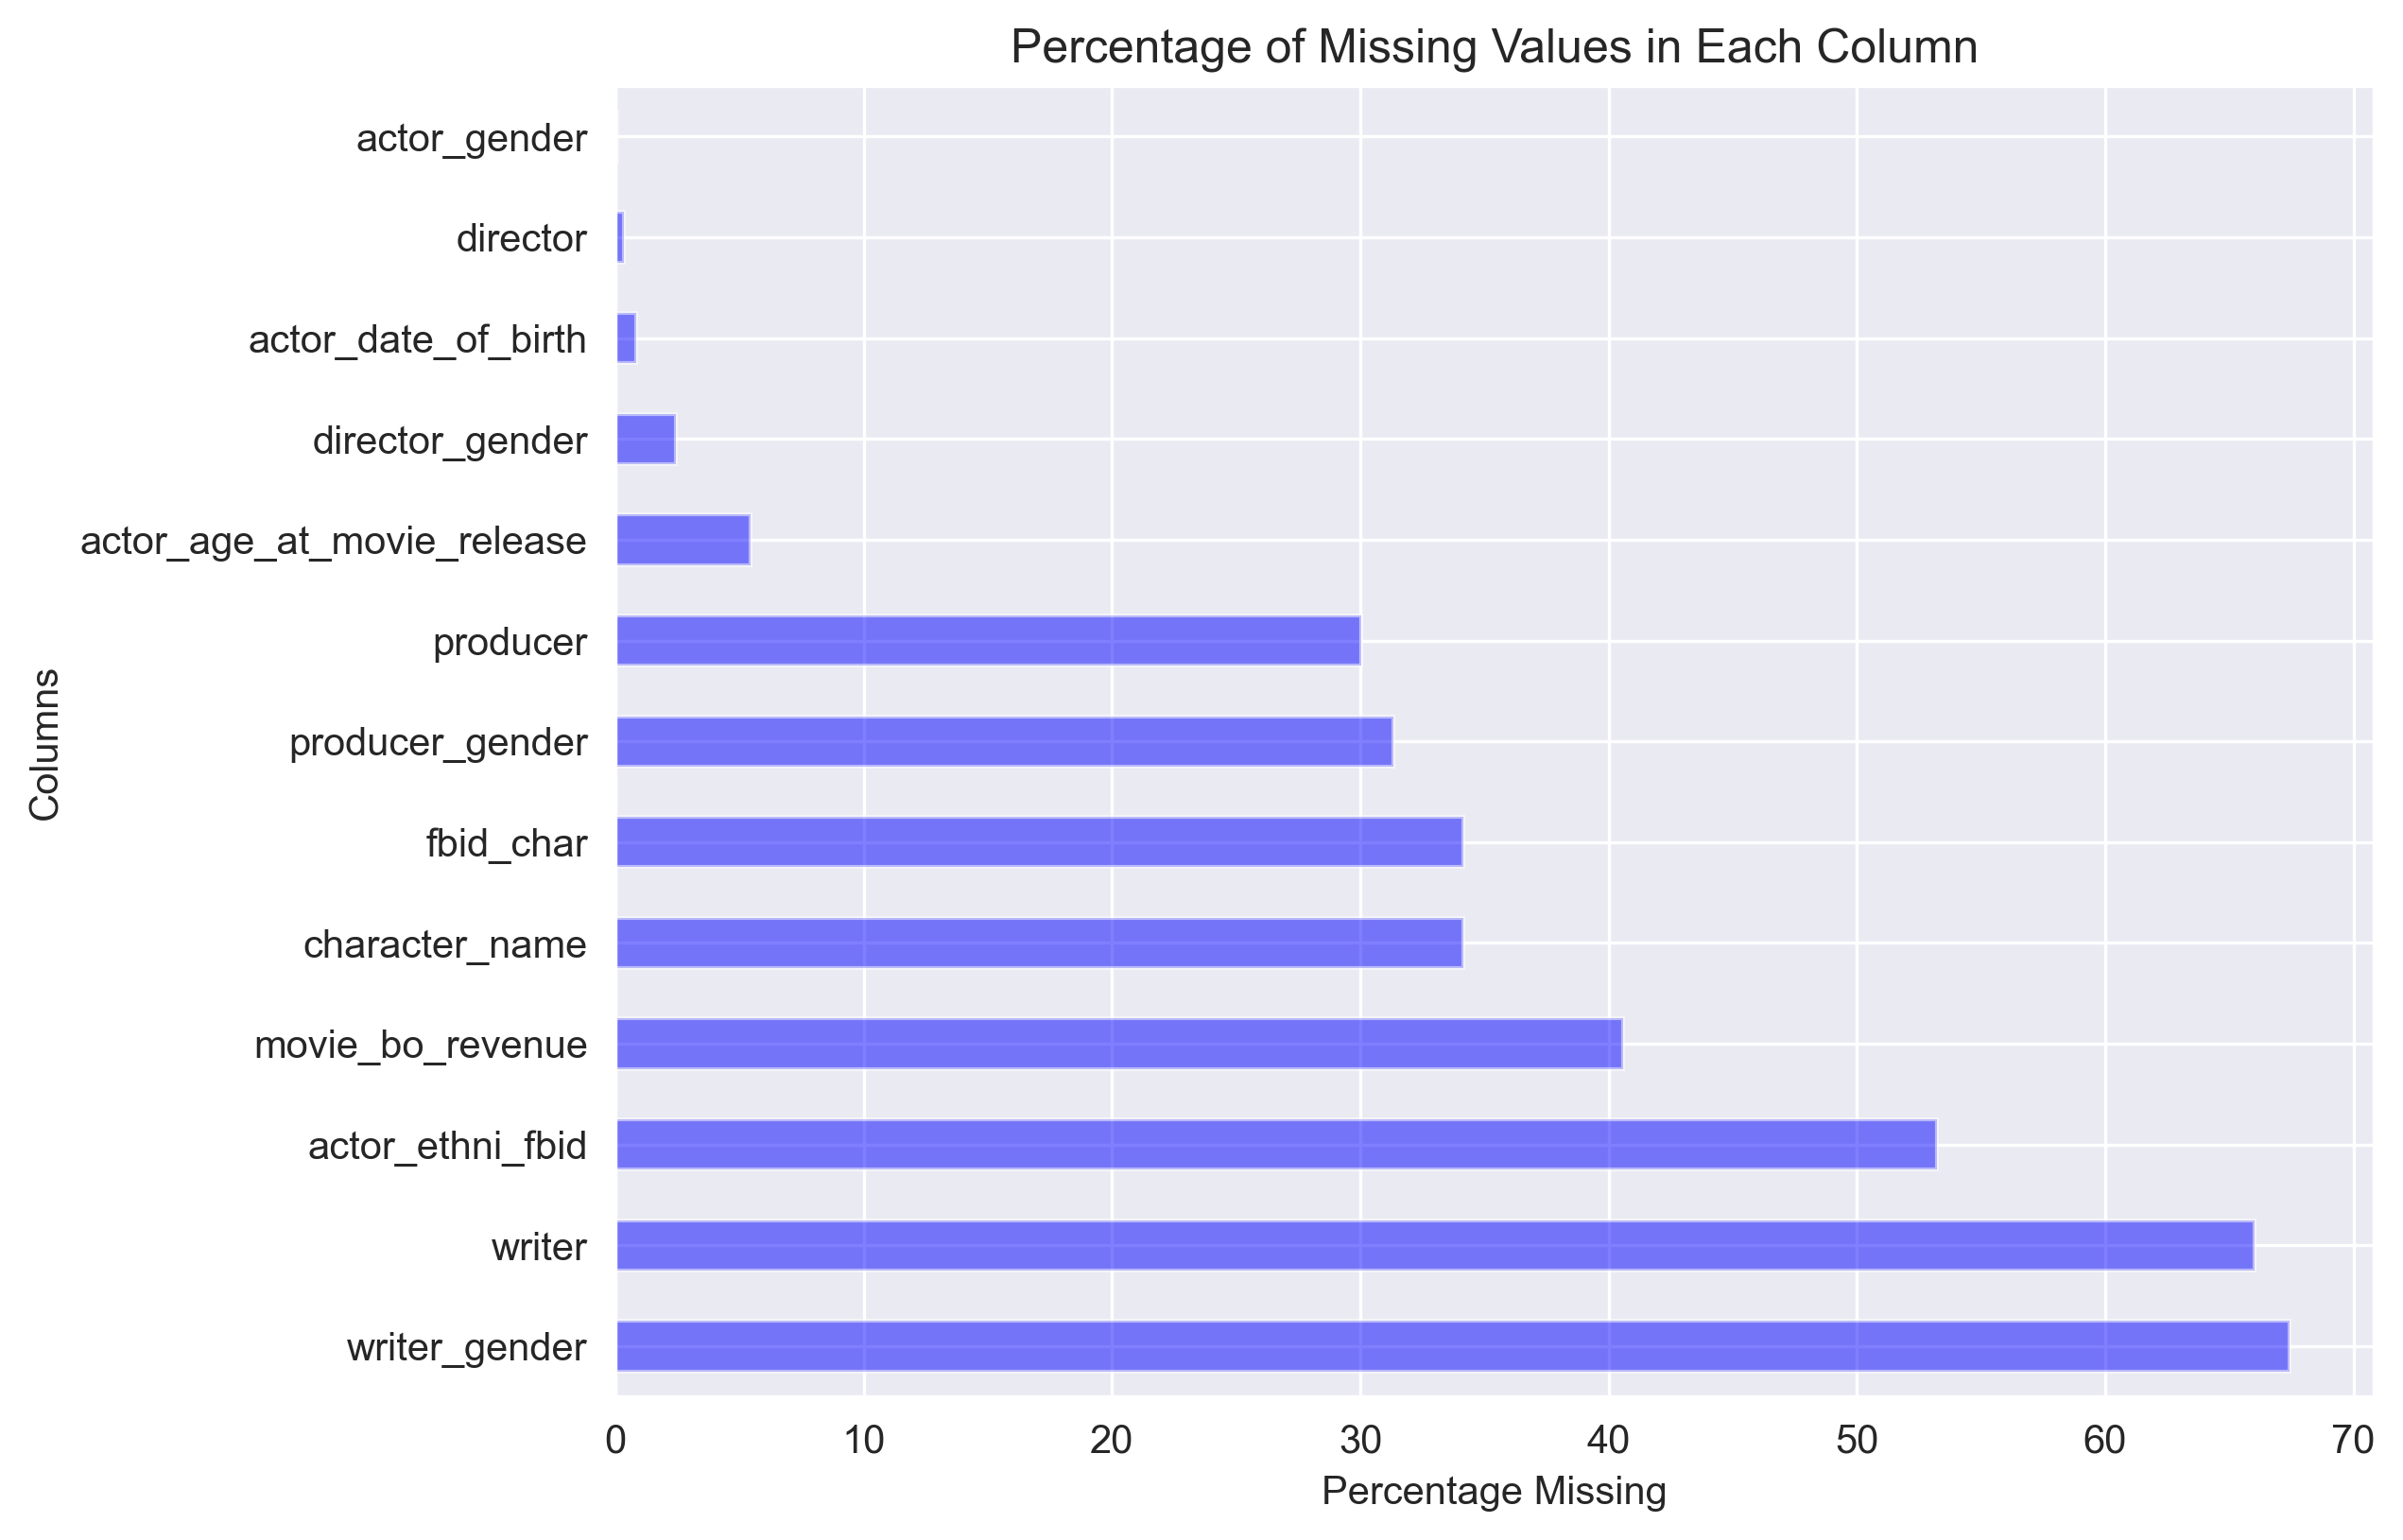

In [9]:
viz.visualize_missing_values(movies)

<div align="justify">

Based on the previous plot, it is evident that there are numerous missing values for the `writer` and `writer_gender` features. Given their limited usability due to this, it's necessary to remove them. Additionally, the `actor_ethni_fbid` feature, which would not have been utilized regardless, should also be dropped.

This correspond to dropping colums with more than 50% of missing values.

</div>

In [10]:
movies = cleaner.clean_missing_values_by_dropping(
    movies, to_drop=["writer", "writer_gender", "actor_ethni_fbid"]
)
display(movies.sample(2))

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,summary,budget,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender
146045,Carla Gallo,23069508,/m/064mg8g,Mother and Child,2009-09-14,4980736.0,127.0,[English Language],"[United States of America, Spain]","[Romantic drama, Romance Film, Drama]",...,"When she was 14, Karen became pregnant and ga...",7000000,3.373907,6.7,1121977,37080,Rodrigo García,M,NaN,NaN
7611,John Ratzenberger,920613,/m/03q0r1,Cars,2006-06-08,461983149.0,116.0,"[Japanese Language, Italian Language, Yiddish ...",[United States of America],"[Adventure, Children's/Family, Computer Animat...",...,Cars takes place in a world populated by anthr...,120000000,18.907948,6.6,0317219,920,John Lasseter,M,Darla K. Anderson,F


Now our dataset is cleaned and useable!

## 3. Distribution of Key Features

In this section, we will examine the distribution of women in various sectors of the movie industry. To begin, let's visualize the distribution of men and women across three roles: actors, film directors, and producers.

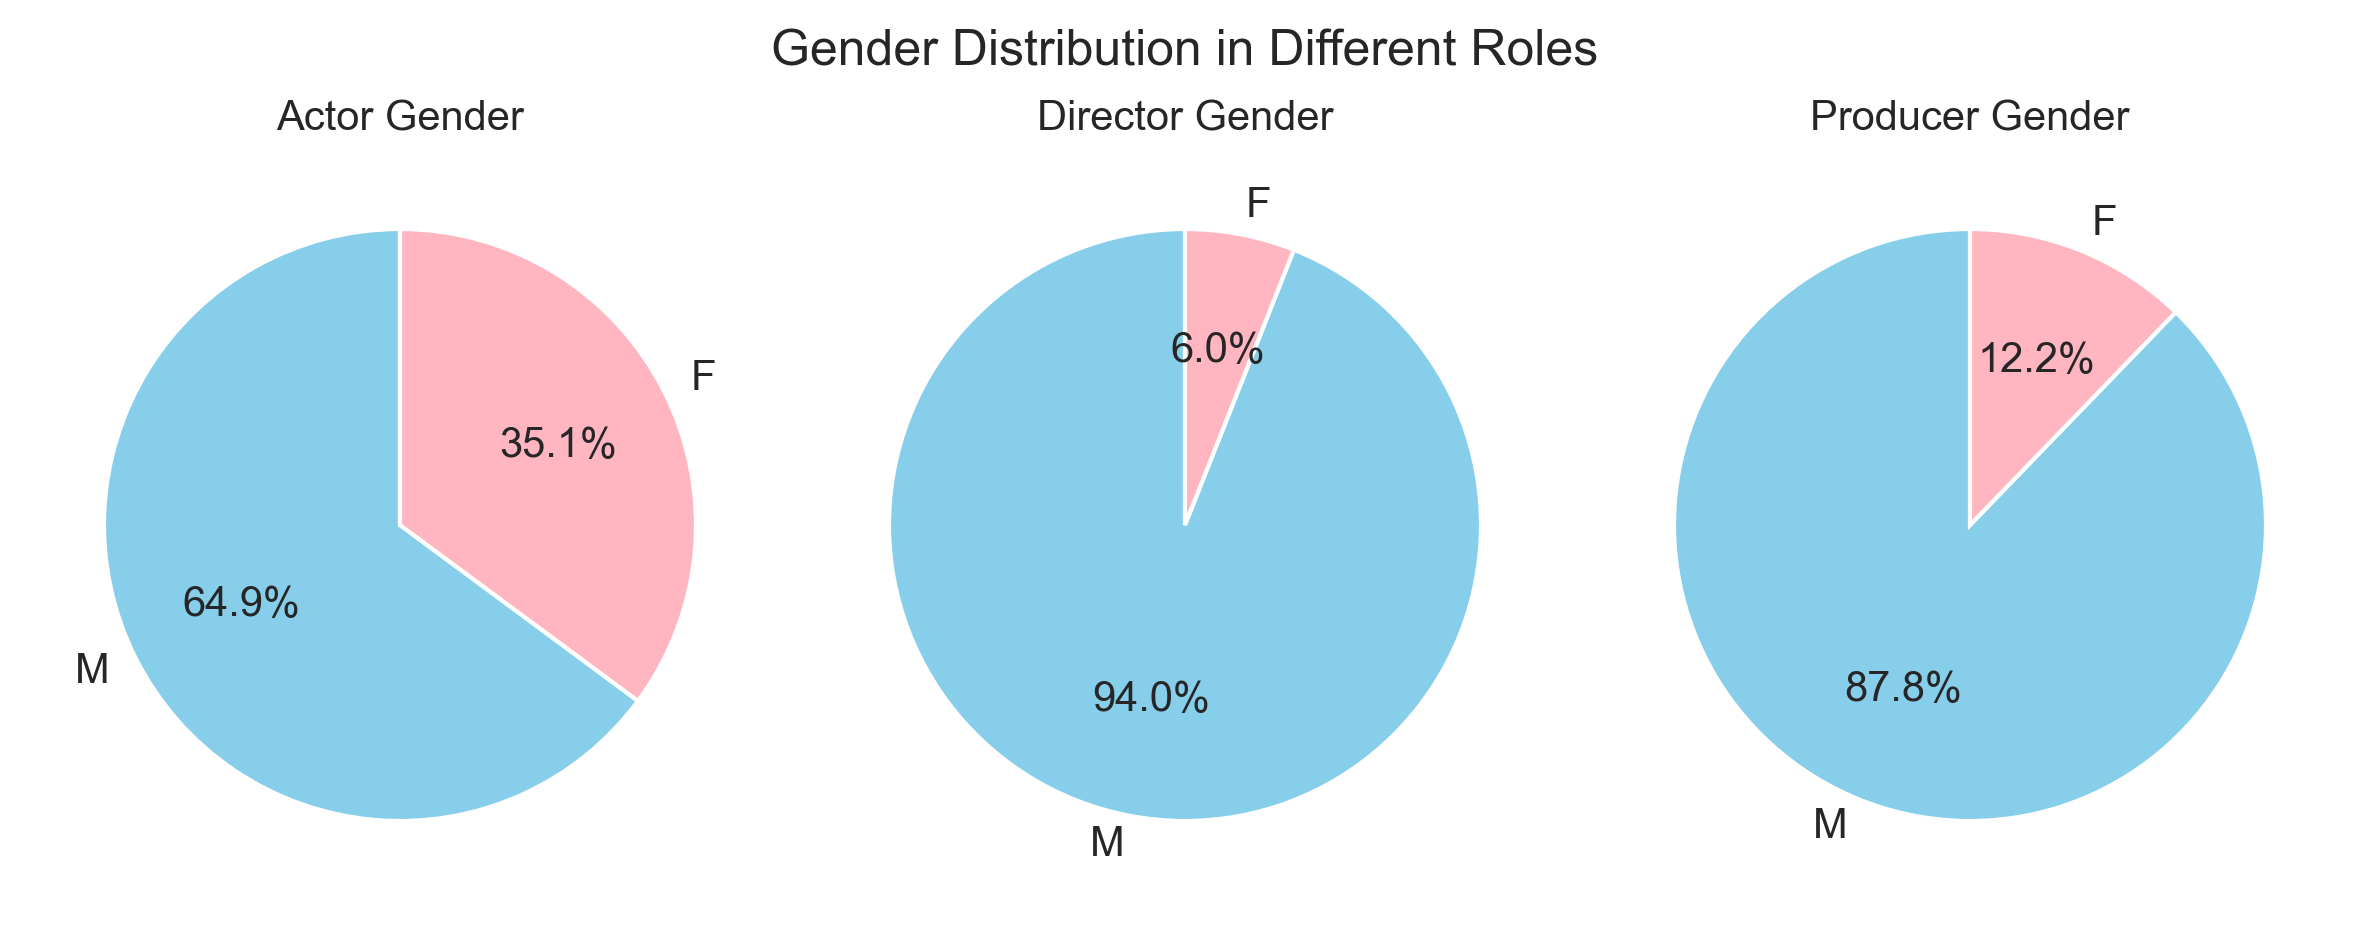

In [11]:
viz.visualize_gender_distribution(movies)

One can clearly see that women are underrepresented both in front of the camera and behind the scenes.

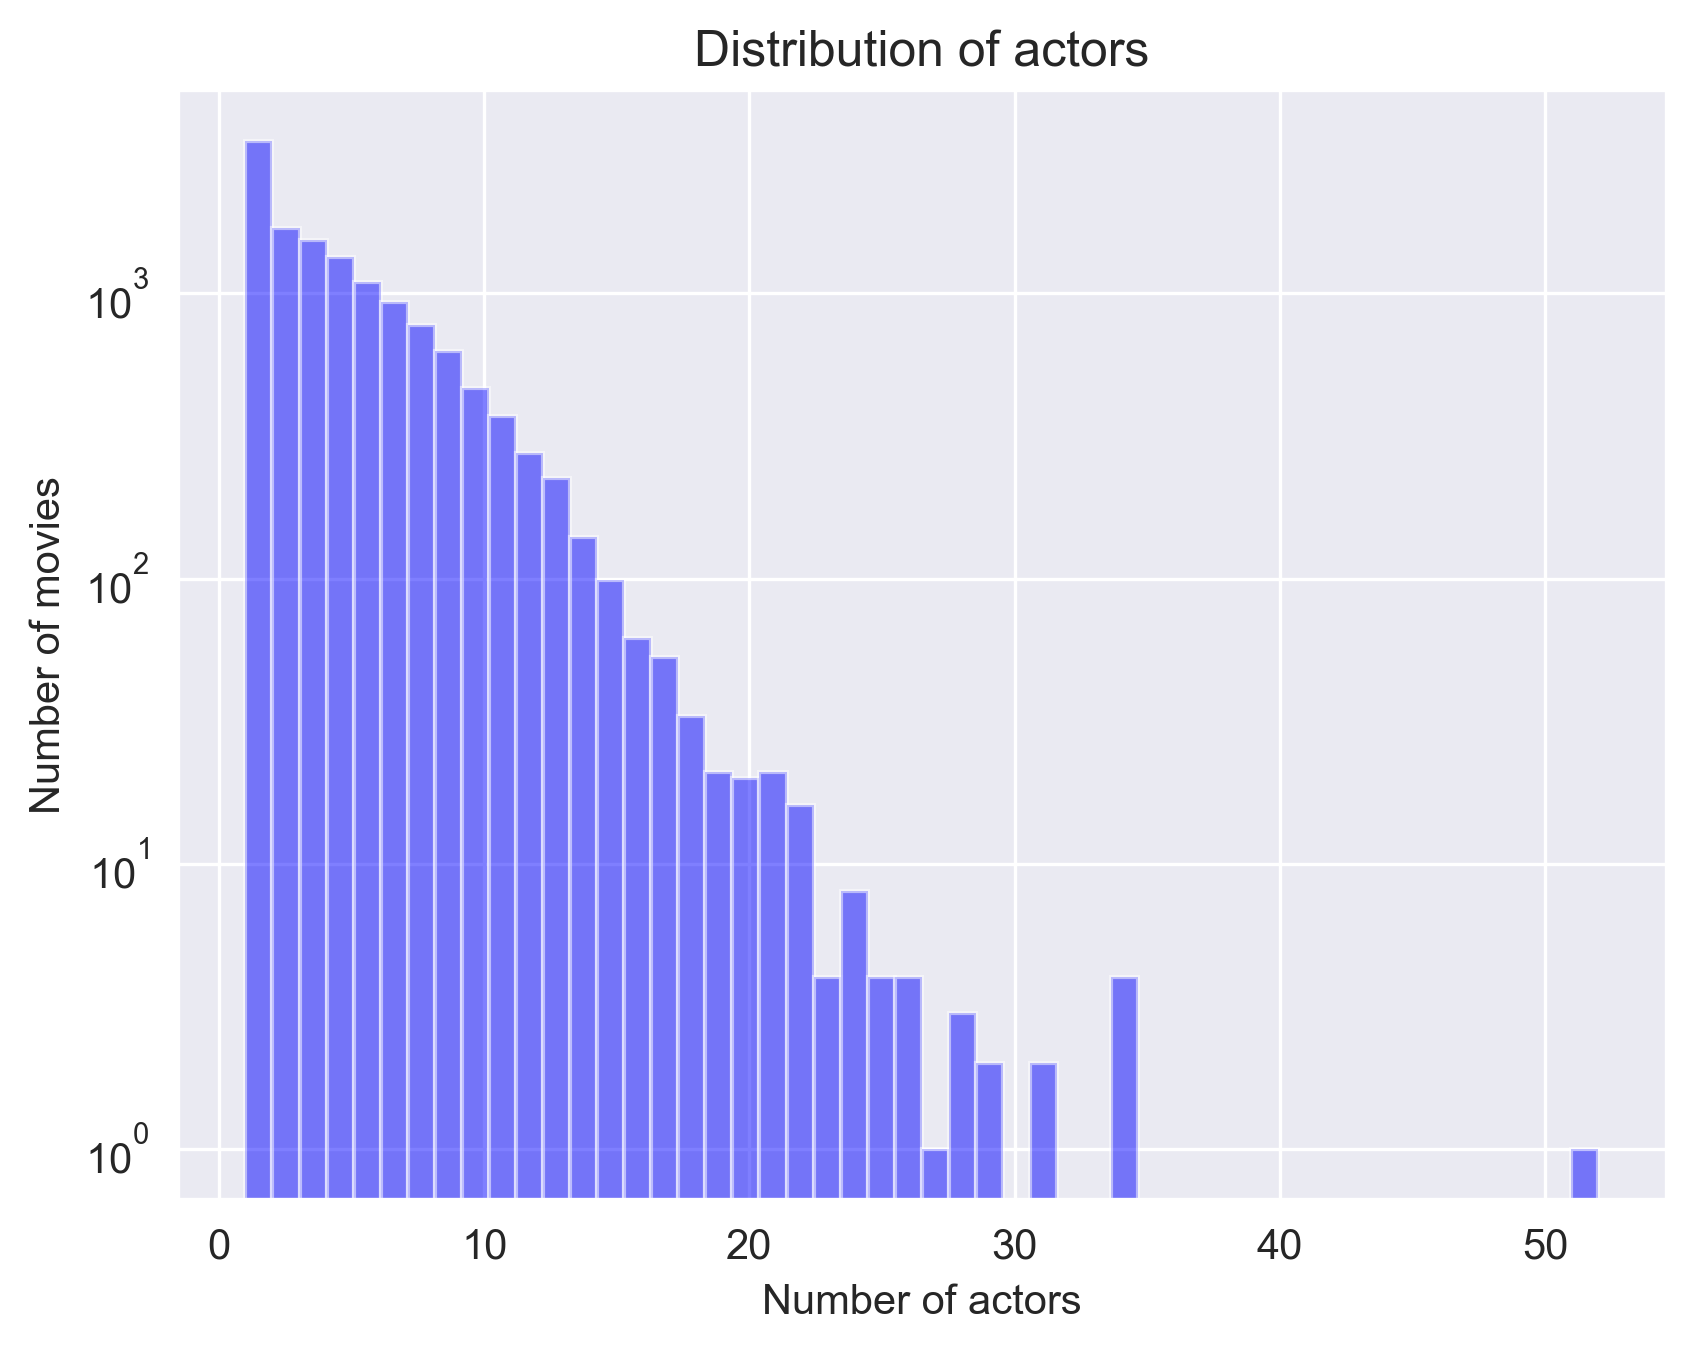

In [12]:
viz.visualize_actors_distribution(movies)

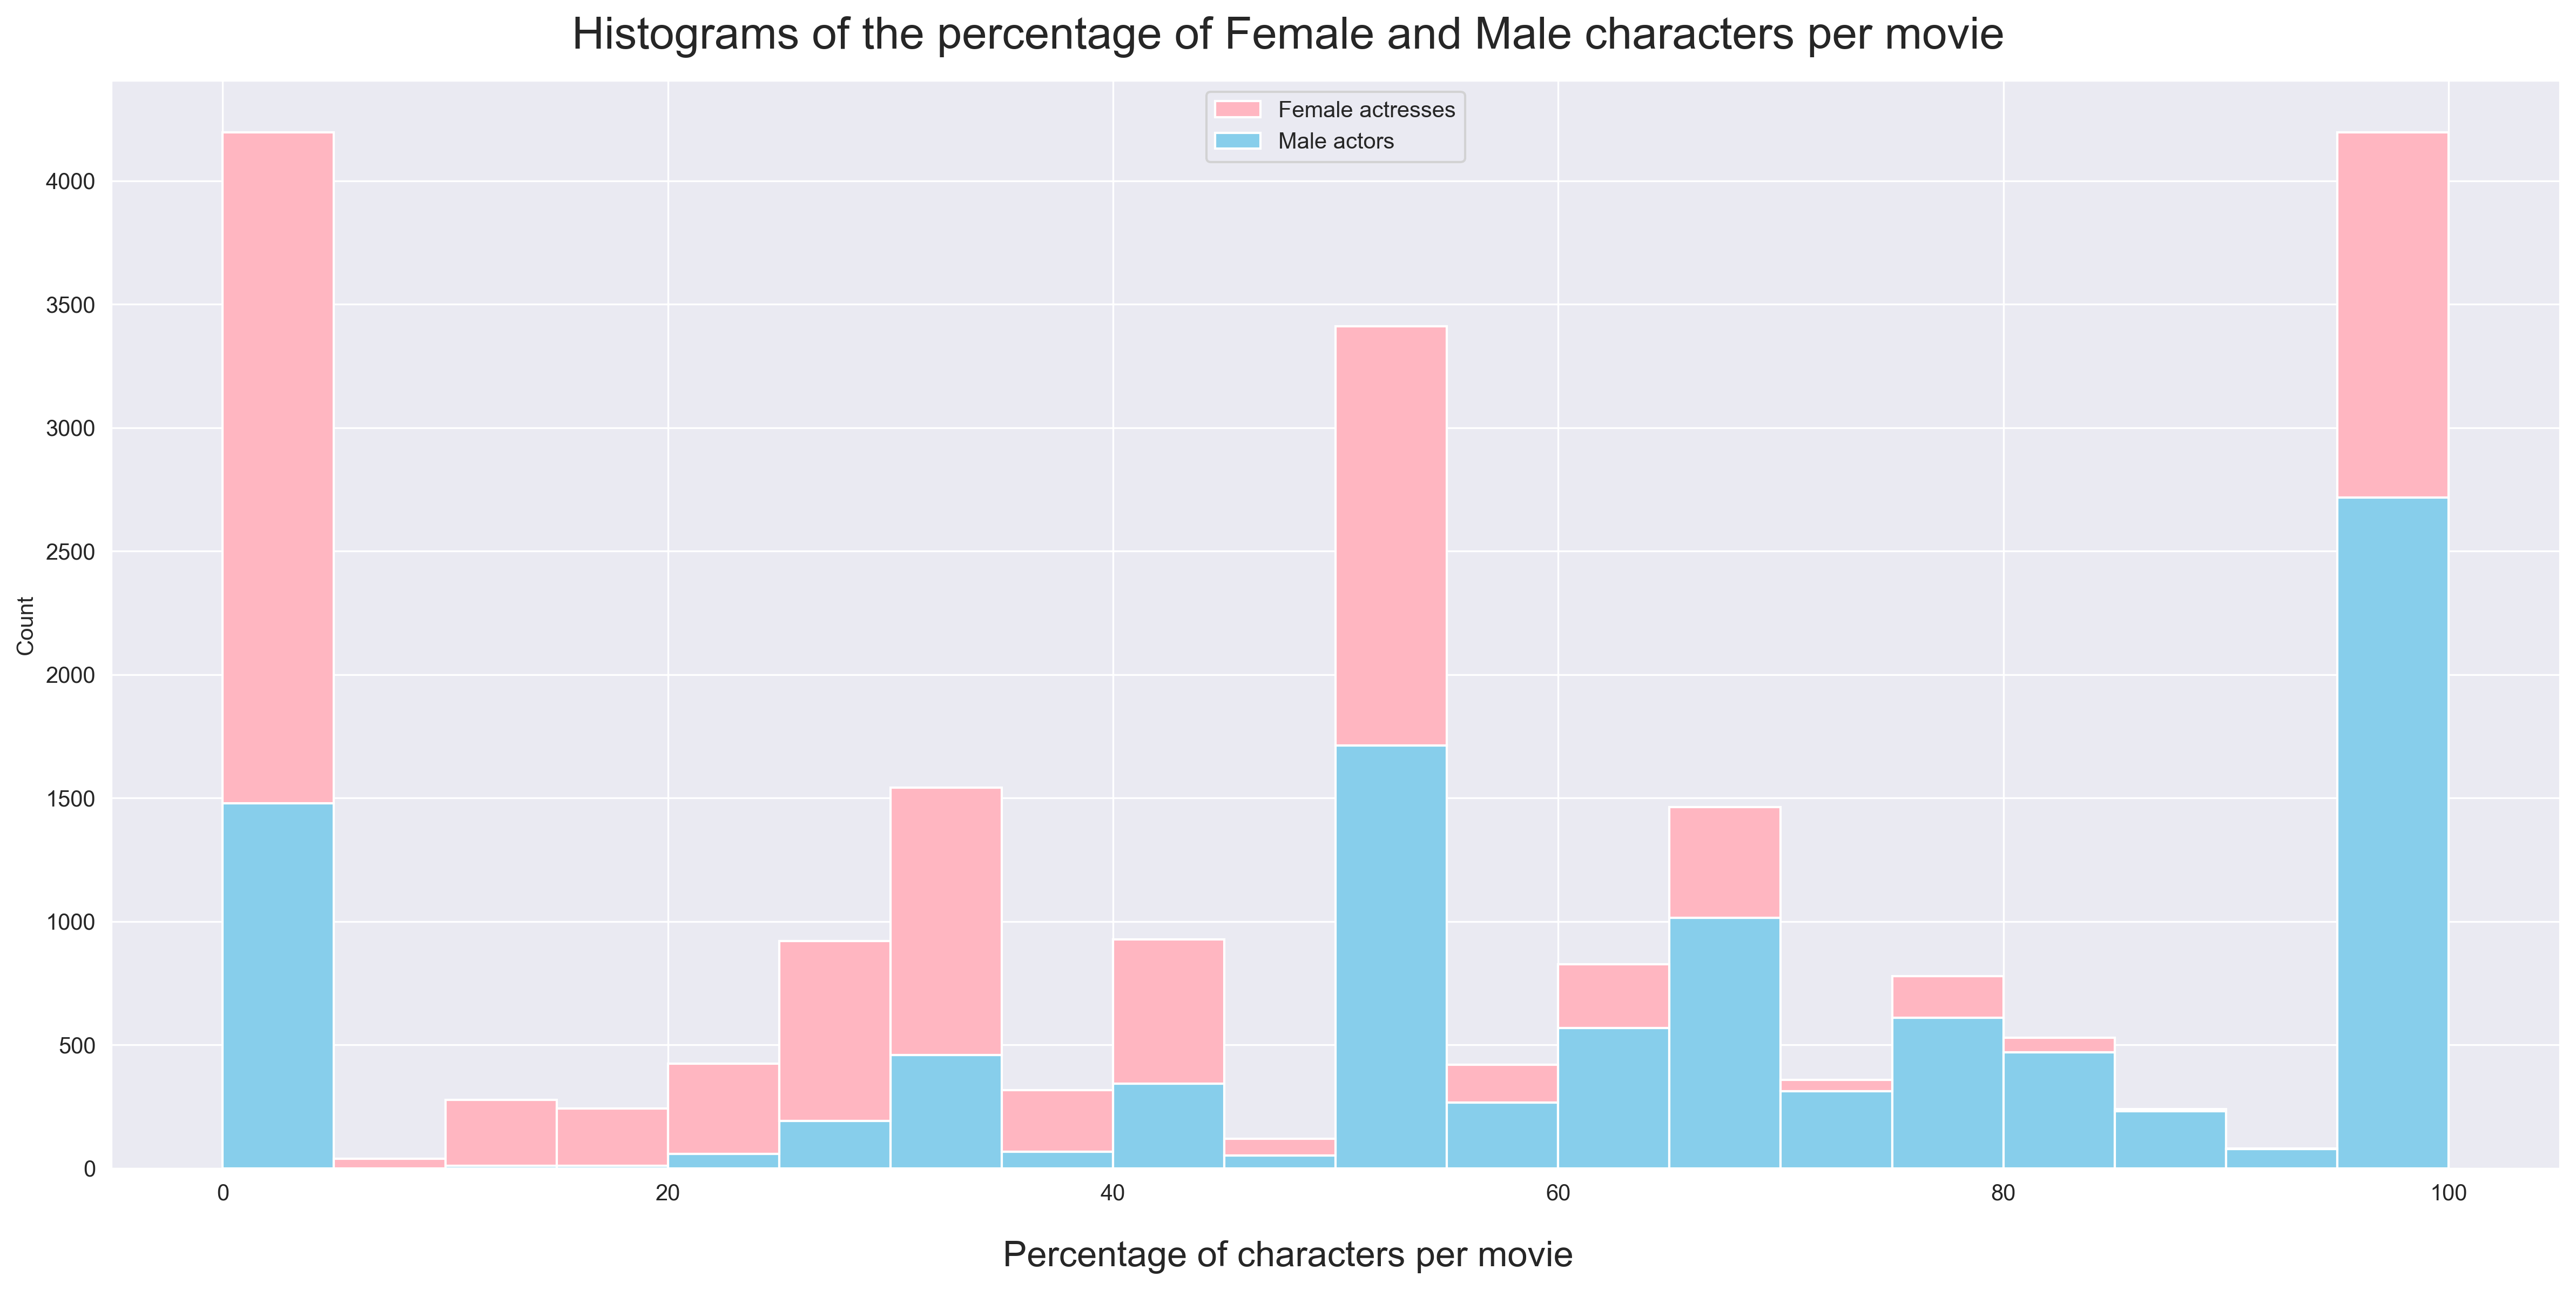

In [13]:
male_female_prop = viz.visualize_gender_prop(movies)

Here, it is evident that the proportion of movies with no women actors is significantly larger, while conversely, there is a substantial number of movies that feature only male actors.


## 4. Is there a link between popularity and proportion of Women in a movie ?

In [14]:
movies_gender_prop = pd.merge(movies, male_female_prop, on=["wikiID", "year"])
movies_gender_prop.drop_duplicates(subset=["movie_title"], inplace=True)

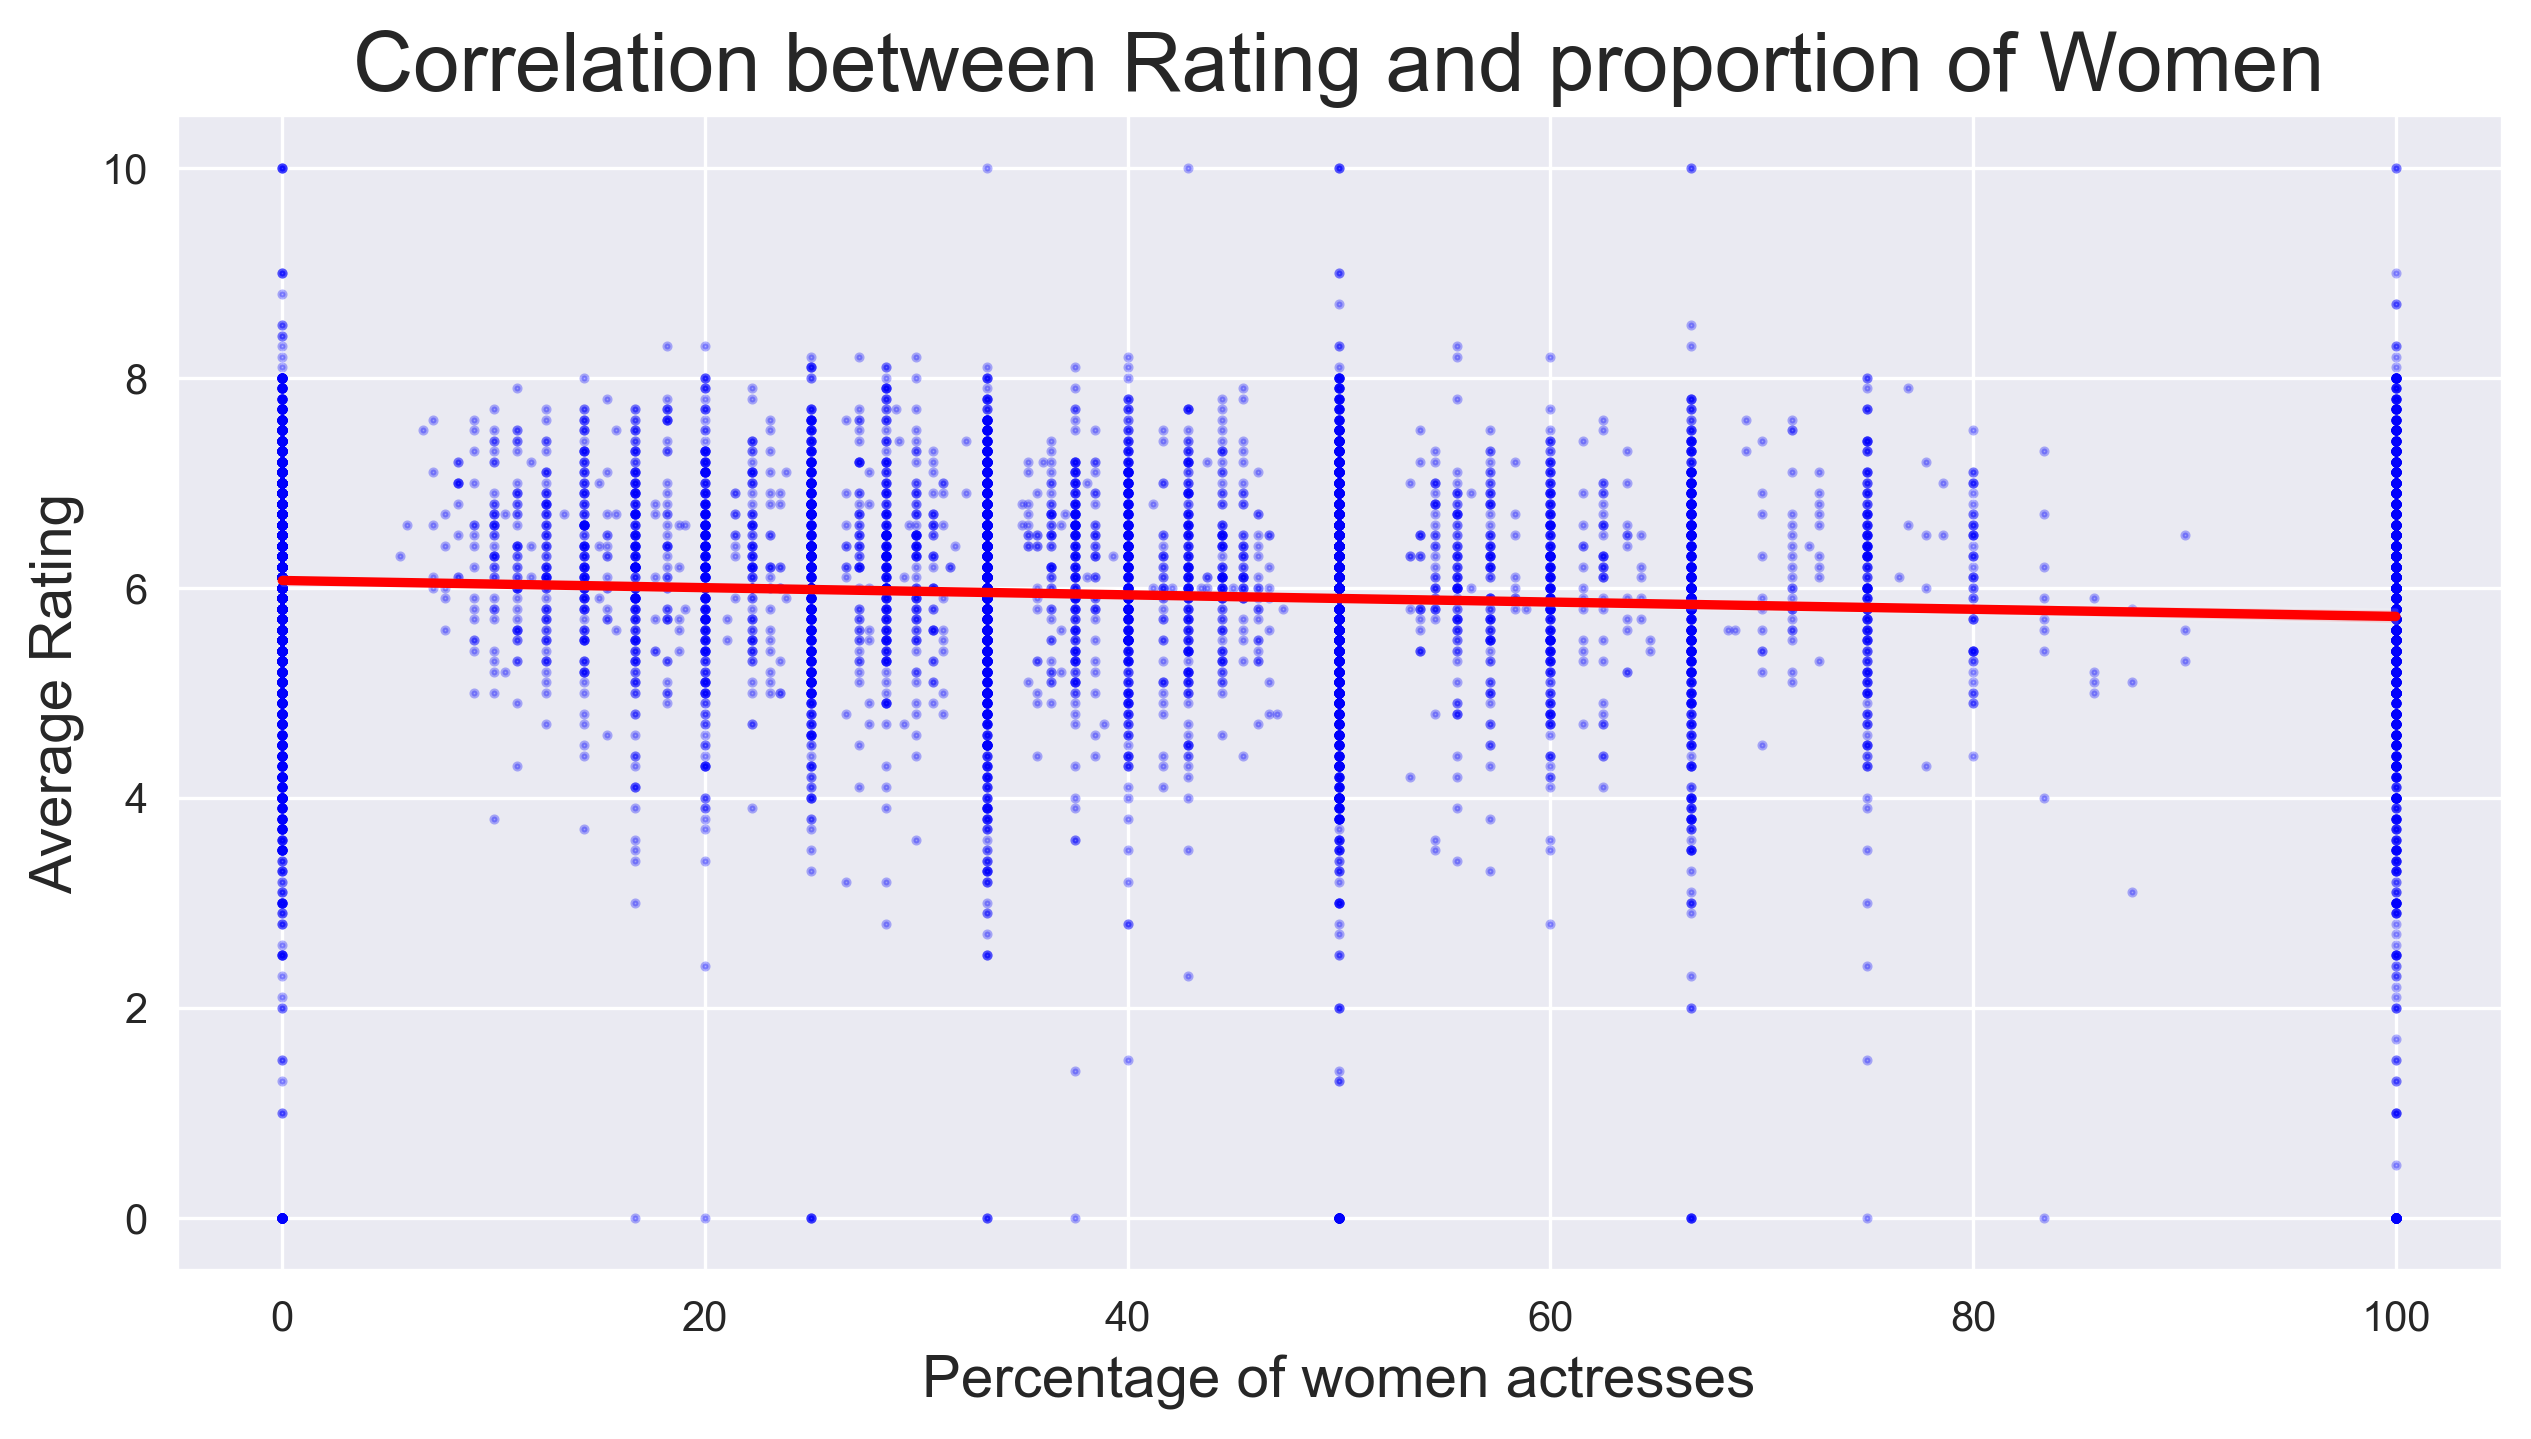

In [15]:
movies_gender_prop = movies_gender_prop.sort_values(
    by="percents_of_female", ascending=True
)

viz.visualize_regression(movies_gender_prop)

We can observe a slight negative correlation, indicating that a movie that highlights women more is less well-received by the audience.

In [16]:
# Compute Pearson Correlation between the popularity and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"].astype(float),
        movies_gender_prop["popularity"].astype(float),
    )
)

# Compute Pearson Correlation between the vote average and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"], movies_gender_prop["vote_average"]
    )
)

PearsonRResult(statistic=-0.1082611010471036, pvalue=2.4719681052451773e-28)
PearsonRResult(statistic=-0.09131447861286039, pvalue=1.362114952102677e-20)


**Conclusion** : Since the $p$-value is low, the result is significative and one can deduce a negative correlation between the proportion of female and the success of a movie. This is already useful to know since it will be used in milestone P3

## 5. Is there a difference regarding age between men an women ?

### 5.1 Average Difference ? 

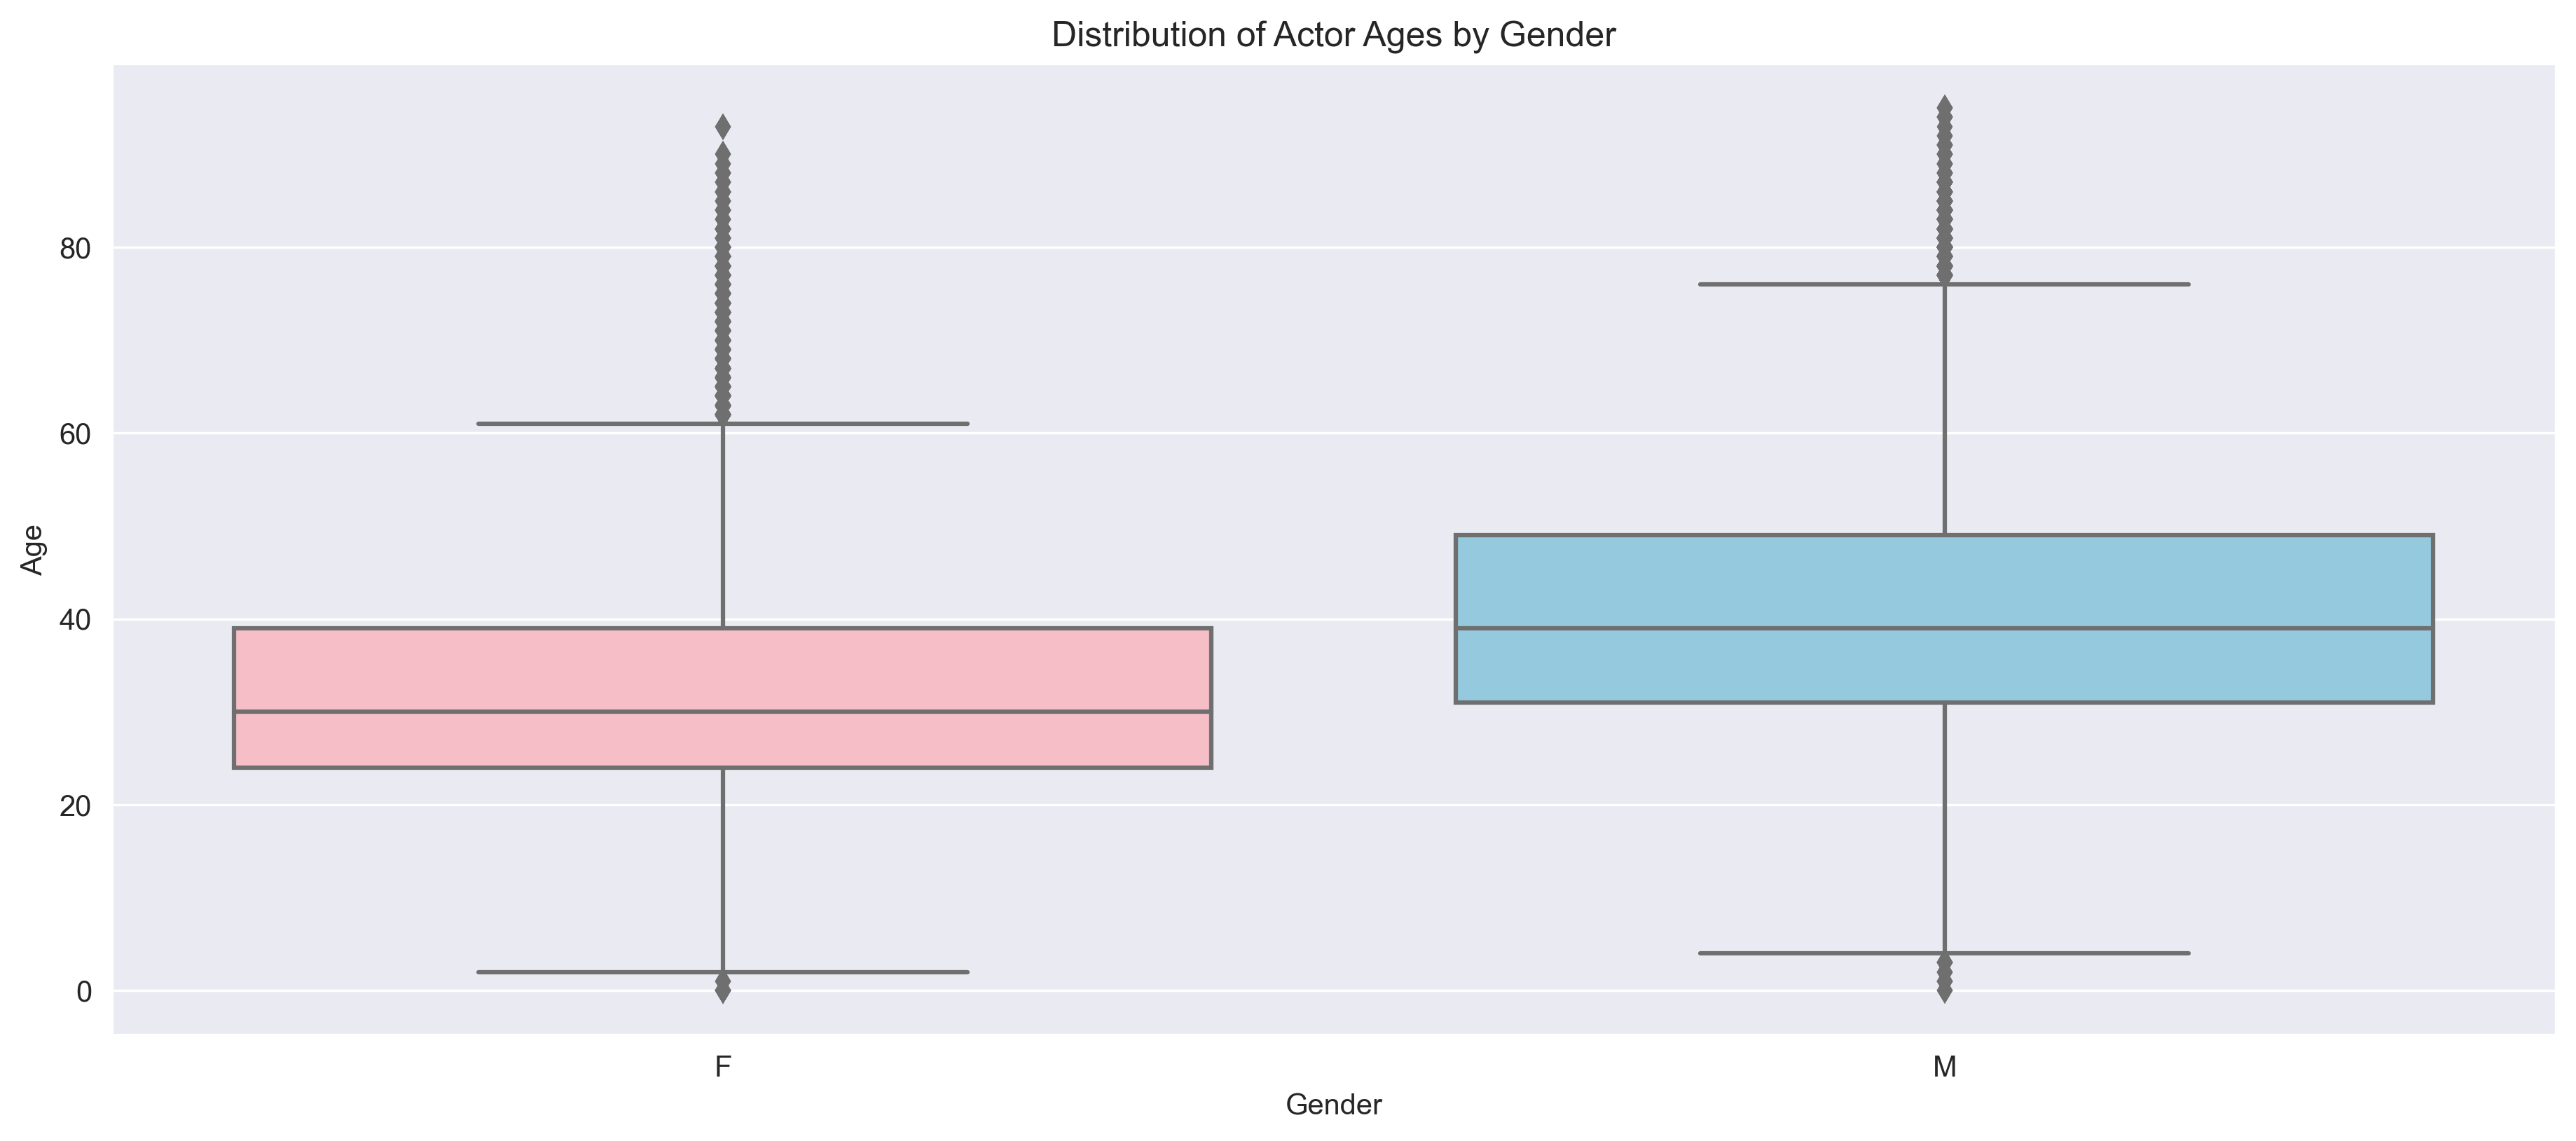

In [17]:
viz.visualize_age_distribution_by_gender(movies)

We can observe that men are older in average. Let's make a $T$-test to see if the difference is significant.

In [18]:
women_age = movies[movies["actor_gender"] == "F"]["actor_age_at_movie_release"]
men_age = movies[movies["actor_gender"] == "M"]["actor_age_at_movie_release"]

# T-test to determine if the difference in age between men and women is statistically significant
print(stats.ttest_ind(women_age, men_age, nan_policy="omit"))

Ttest_indResult(statistic=-73.08335051739951, pvalue=0.0)


The results of the $T$-test suggest that there is a statistically significant difference in average age of actors ($p$-value < 0.05). As the $T$-statistic is strongly negative (-73), we conclude that actresses are significantly younger than male actors.

### 5.2 Evolution of age distribution in the movie industry

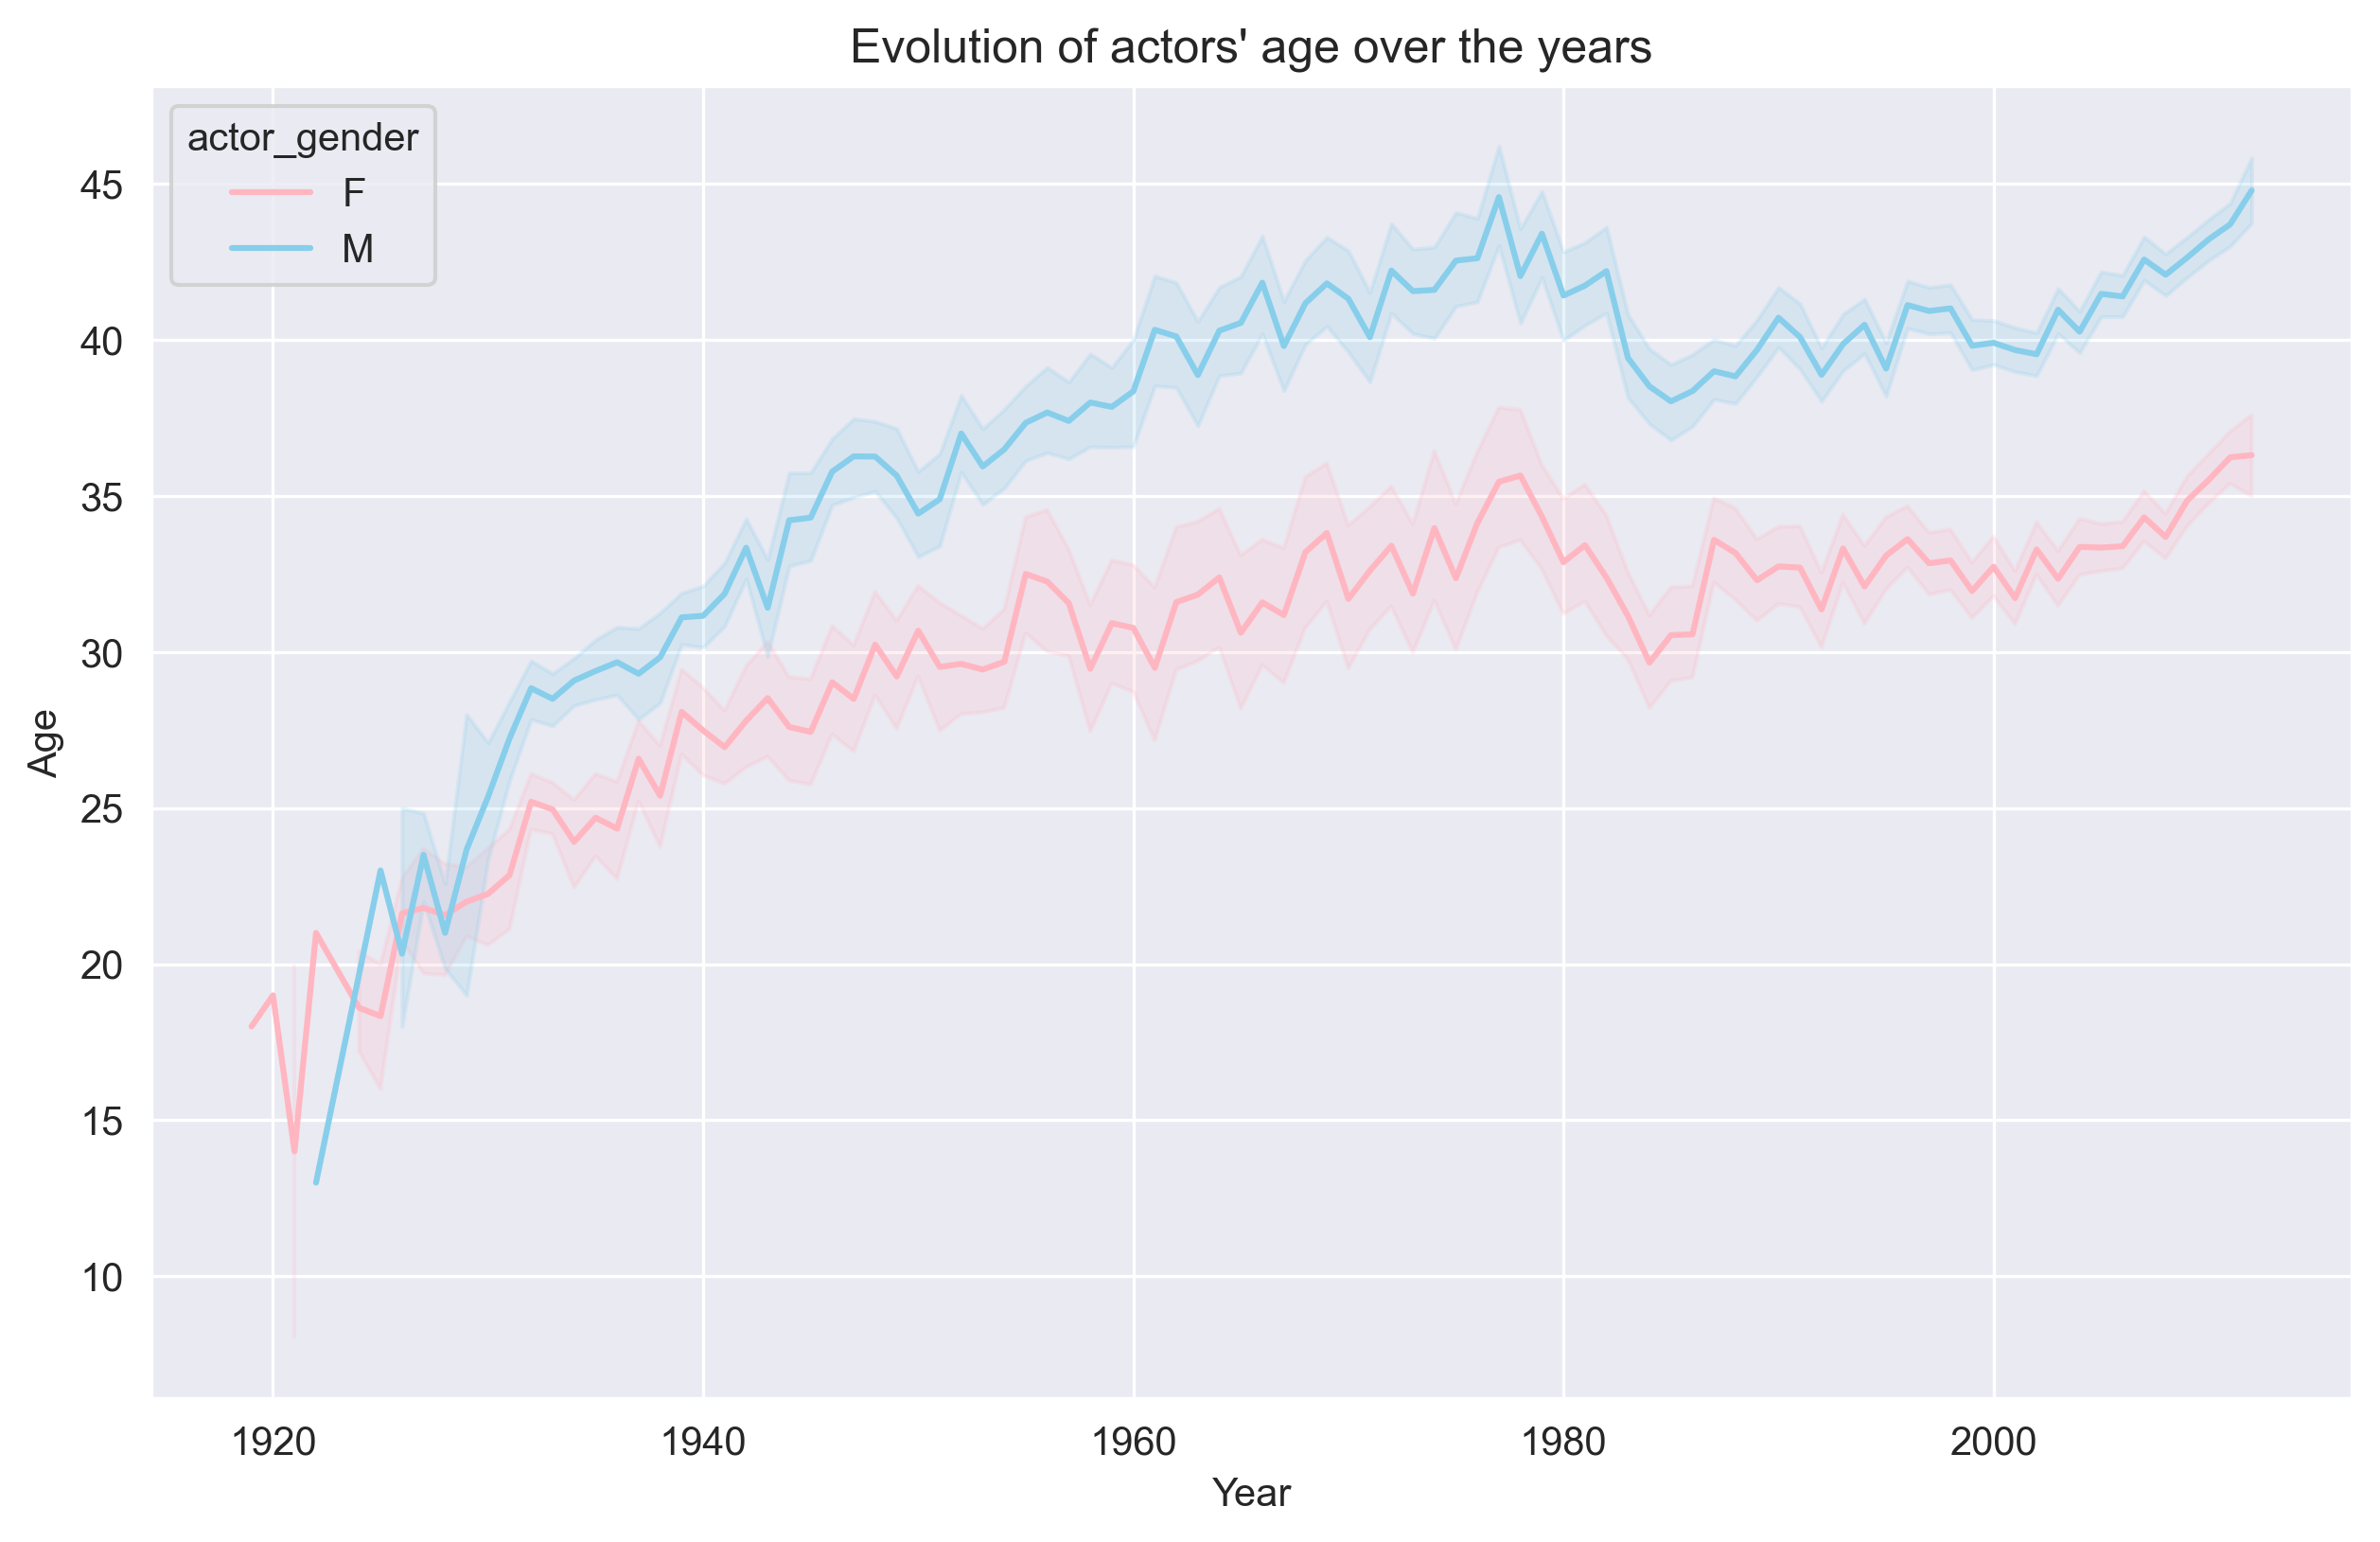

In [19]:
viz.visualize_age_evolution(movies)

It's noticeable that from the 1920s onward, the film industry tends to depict male actors who are older than their female counterparts.

## 6. Bechdel test

In this section we will start exploring the Bechdel dataset.

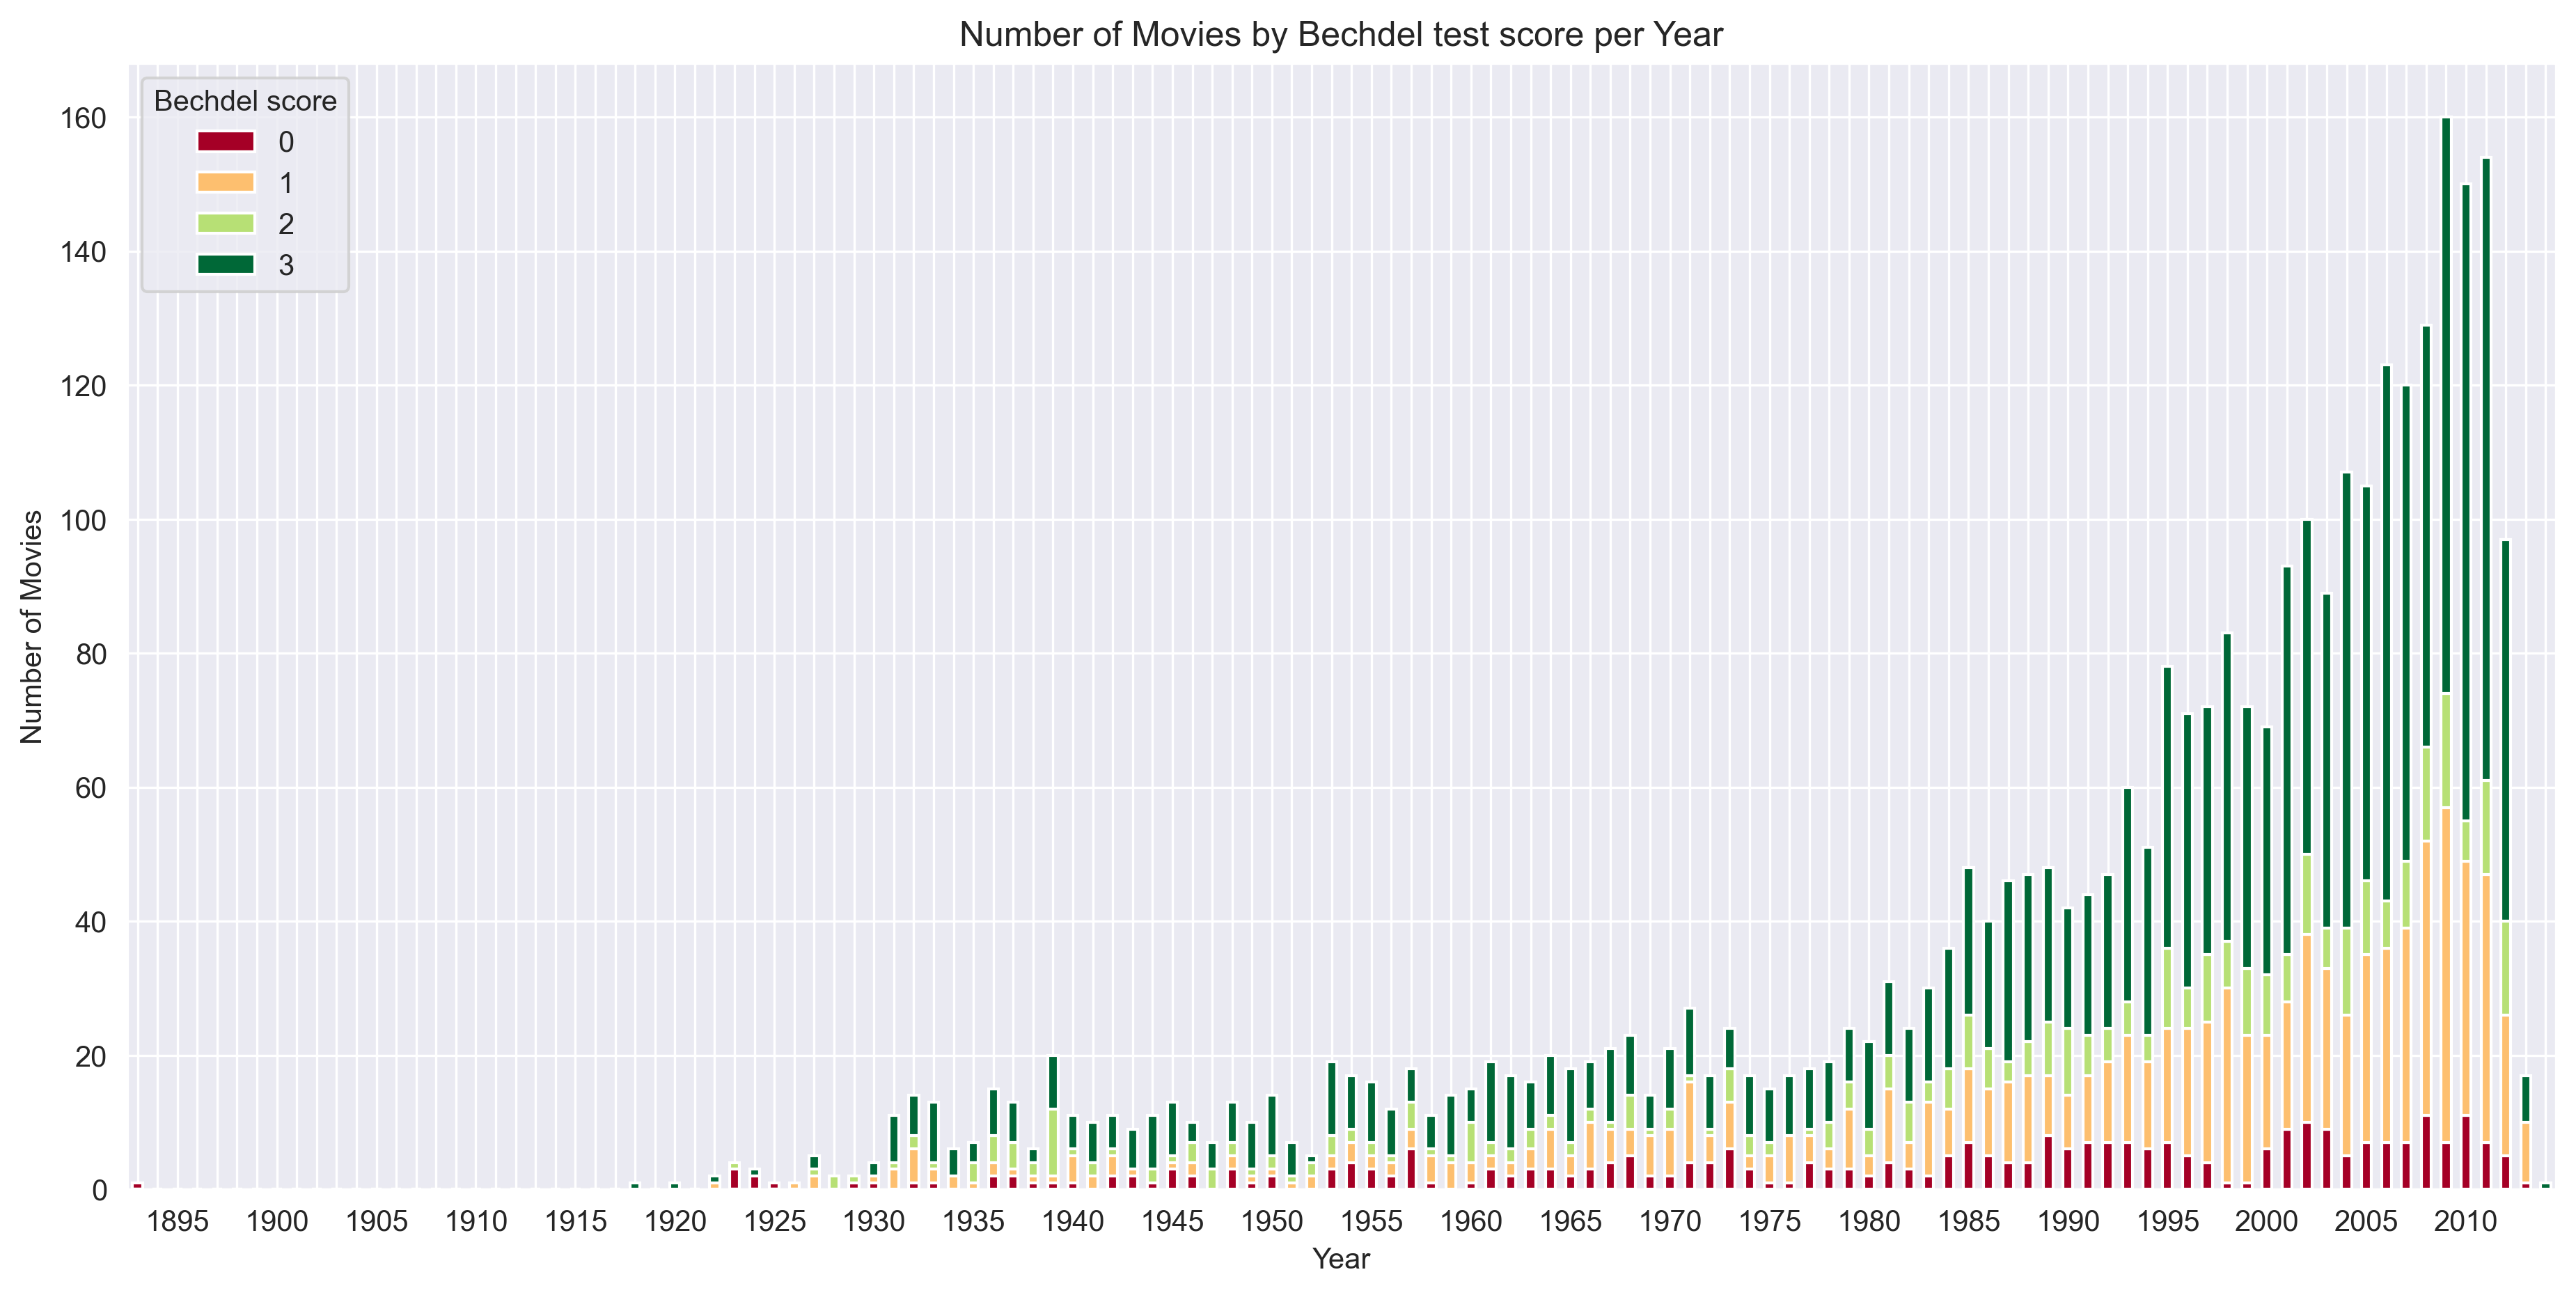

In [20]:
viz.visualize_bechdel_distribution(movies_with_bechdel)

We see, with no surprize, that most movies entered in the Bechdel test are from the 2000s.

---

# NLP on Plot Summaries

The goal here is to preprocess the summaries by tokenizing them and then conduct an initial analysis of the "feminism" aspect in the summaries by calculating a basic "femininity score." More in-depth analyses, including sentiment analysis, will be carried out in milestone P3.



## 1. Preprocessing of the texts and cleaning

In [27]:
nlp_summaries = movies[["wikiID", "movie_title", "summary"]].drop_duplicates()
display(nlp_summaries)

,wikiID,movie_title,summary
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th..."
17,171005,Henry V,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
38,77856,Mary Poppins,The film opens with Mary Poppins perched in a...
52,21926710,White on Rice,Jimmy ([[Hiroshi Watanabe loves dinosaurs and...
61,156558,Baby Boy,A young 20-year-old named Jody lives with his...
...,...,...,...
170055,7761830,Spaced Invaders,"The space armada from Mars, known as the Imper..."
170065,1918494,State and Main,Havoc is wrought on the inhabitants of a small...
170088,664006,Guilty as Sin,Jennifer Haines is an up-and-coming Chicago a...
170099,3868432,Into the Mirror,After accidentally causing the death of his pa...


Here, we apply the `clean_text()` from our `nlputils` module which clean the summaries by 

- converting all text to lowercase
- removing any text within square brackets (e.g. citations)
- removing all punctuation
- removing any words containing numbers
- removing any stop words (common words like "the", "and", etc.)

In [28]:
nlp_summaries["summary"] = nlp_summaries["summary"].apply(nlputils.clean_text)
display(nlp_summaries.sample(2))

,wikiID,movie_title,summary
74795,3648312,Aaron Loves Angela,aaron loves angela two teenagers living slums ...
6267,3520805,Genius,charlie boyle physics genius hockey lover tire...


### 1.1 Tokenization

This step conducts a simple tokenization of summaries.

In [29]:
nlp_summaries = nlputils.nlp_tokenize_summaries(nlp_summaries)
display(nlp_summaries.sample(2))

,wikiID,movie_title,summary,tokens,len
47255,972816,Clockwatchers,iris mousy quiet young professional doesnt wan...,"[iris, mousy, quiet, young, professional, does...",1425
148706,32844727,The Breach,hélène régniers mentally ill husband charles i...,"[hélène, régniers, mentally, ill, husband, cha...",476


## 2. Feminity score analysis

### 2.1 Compute the feminity score

Here we compute (a rather simplistic) femininity score of summaries using a list of [words designating females](./nlp/female_keywords.txt).

In [30]:
nlp_summaries = nlputils.nlp_compute_feminity_score(nlp_summaries)
nlp_summaries = pd.merge(nlp_summaries, male_female_prop, on=["wikiID"])
print(
    stats.pearsonr(nlp_summaries["feminity_score"], nlp_summaries["percents_of_female"])
)

PearsonRResult(statistic=0.009207855151971232, pvalue=0.3418781499266348)


The $p$-value is greater than 0.05 and the Pearson correlation coefficient is very small, indicating that we cannot reject the null hypothesis that there is no correlation between the proportion of women and the plot summary. Further analysis is required (will be done in milestone P3).

### 2.2 Distribution of feminity score

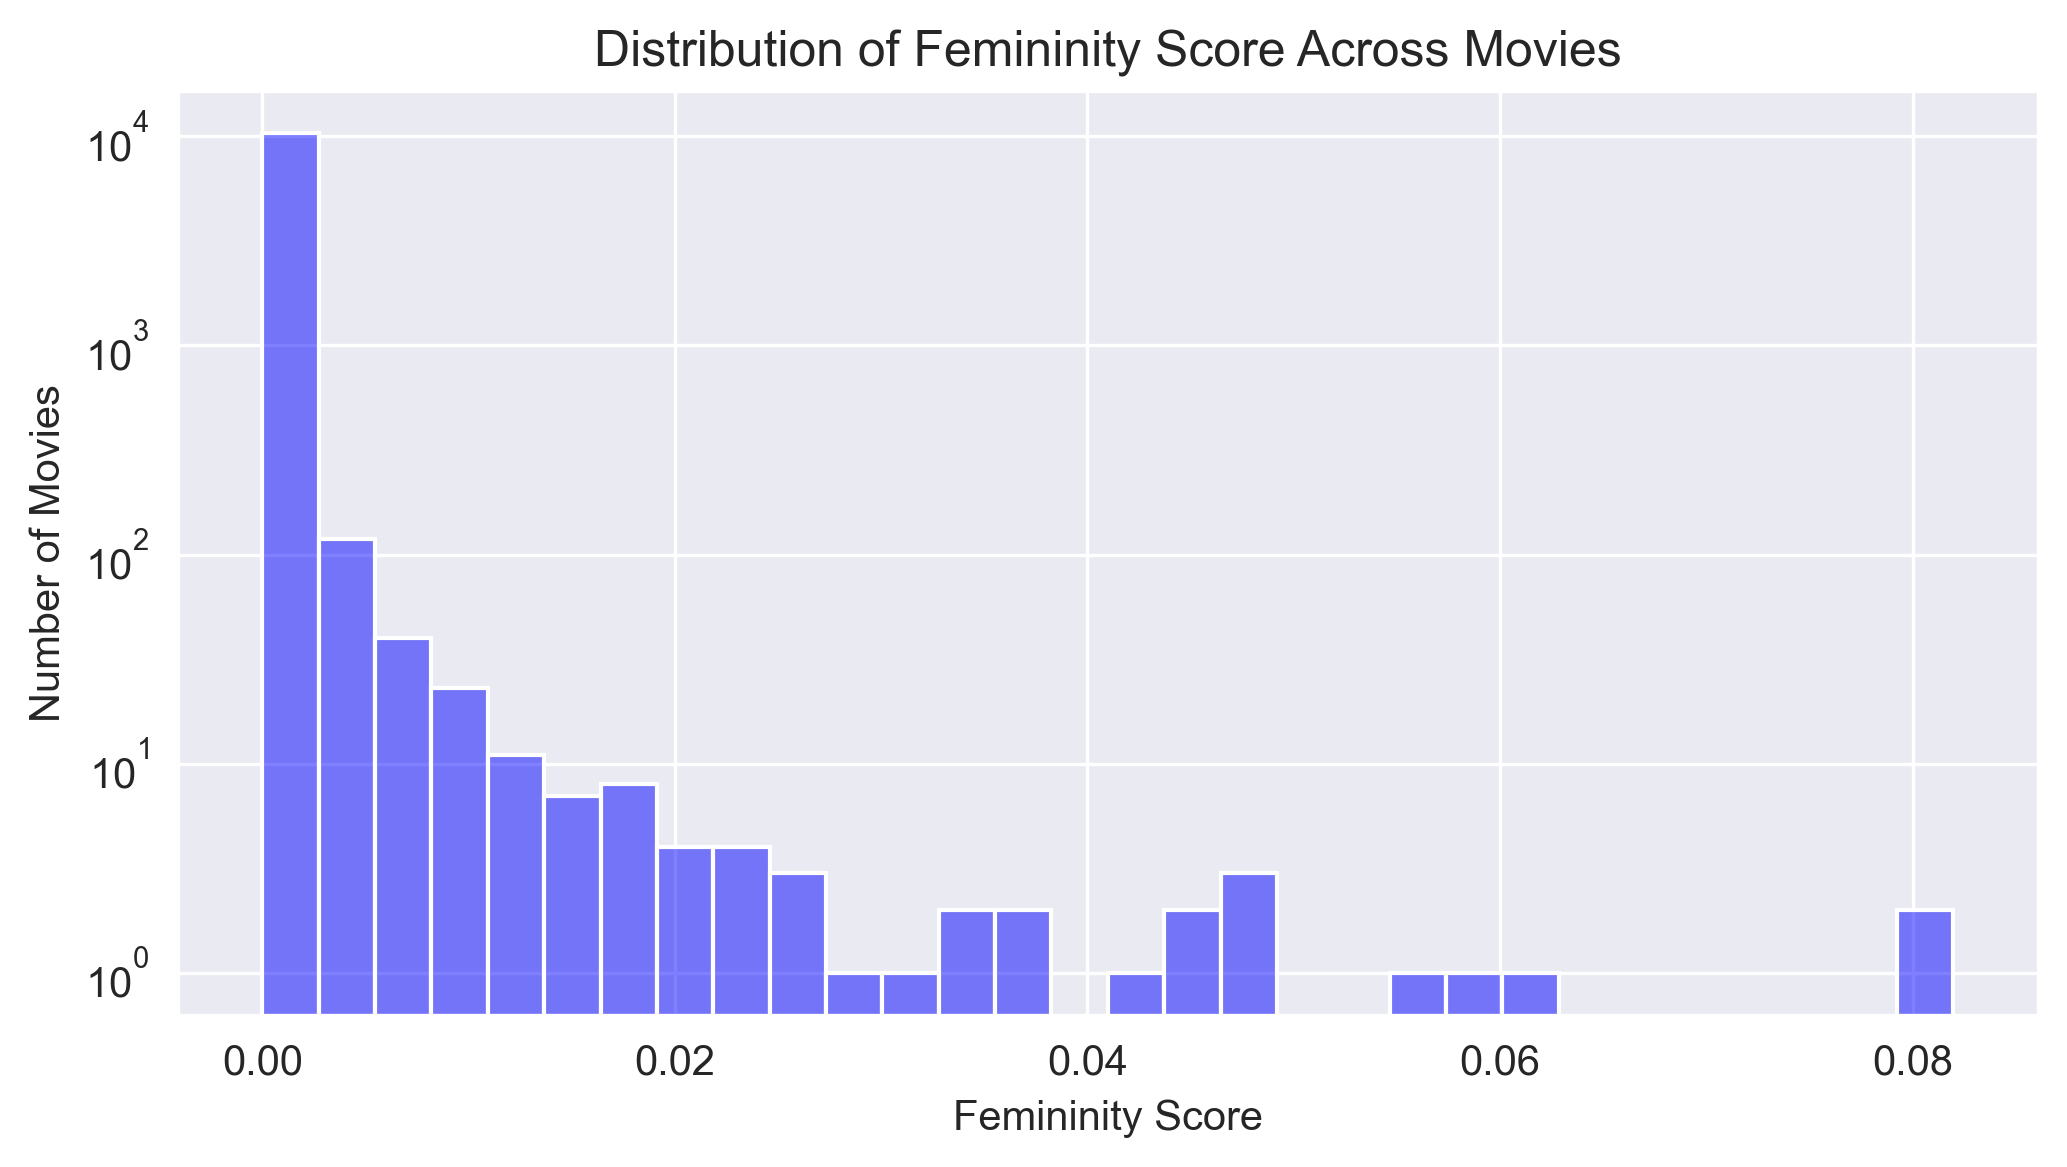

In [31]:
# viz.visualize_feminity_score_distribution(nlp_summaries)
viz.visualize_feminity_score_distribution(nlp_summaries)

As we can observe, there are numerous movies with a low femininity score, which confirms the findings of the previous test. It's also important to note that the femininity score is not perfect and rather simplistic. This will be enhanced in milestone P3.

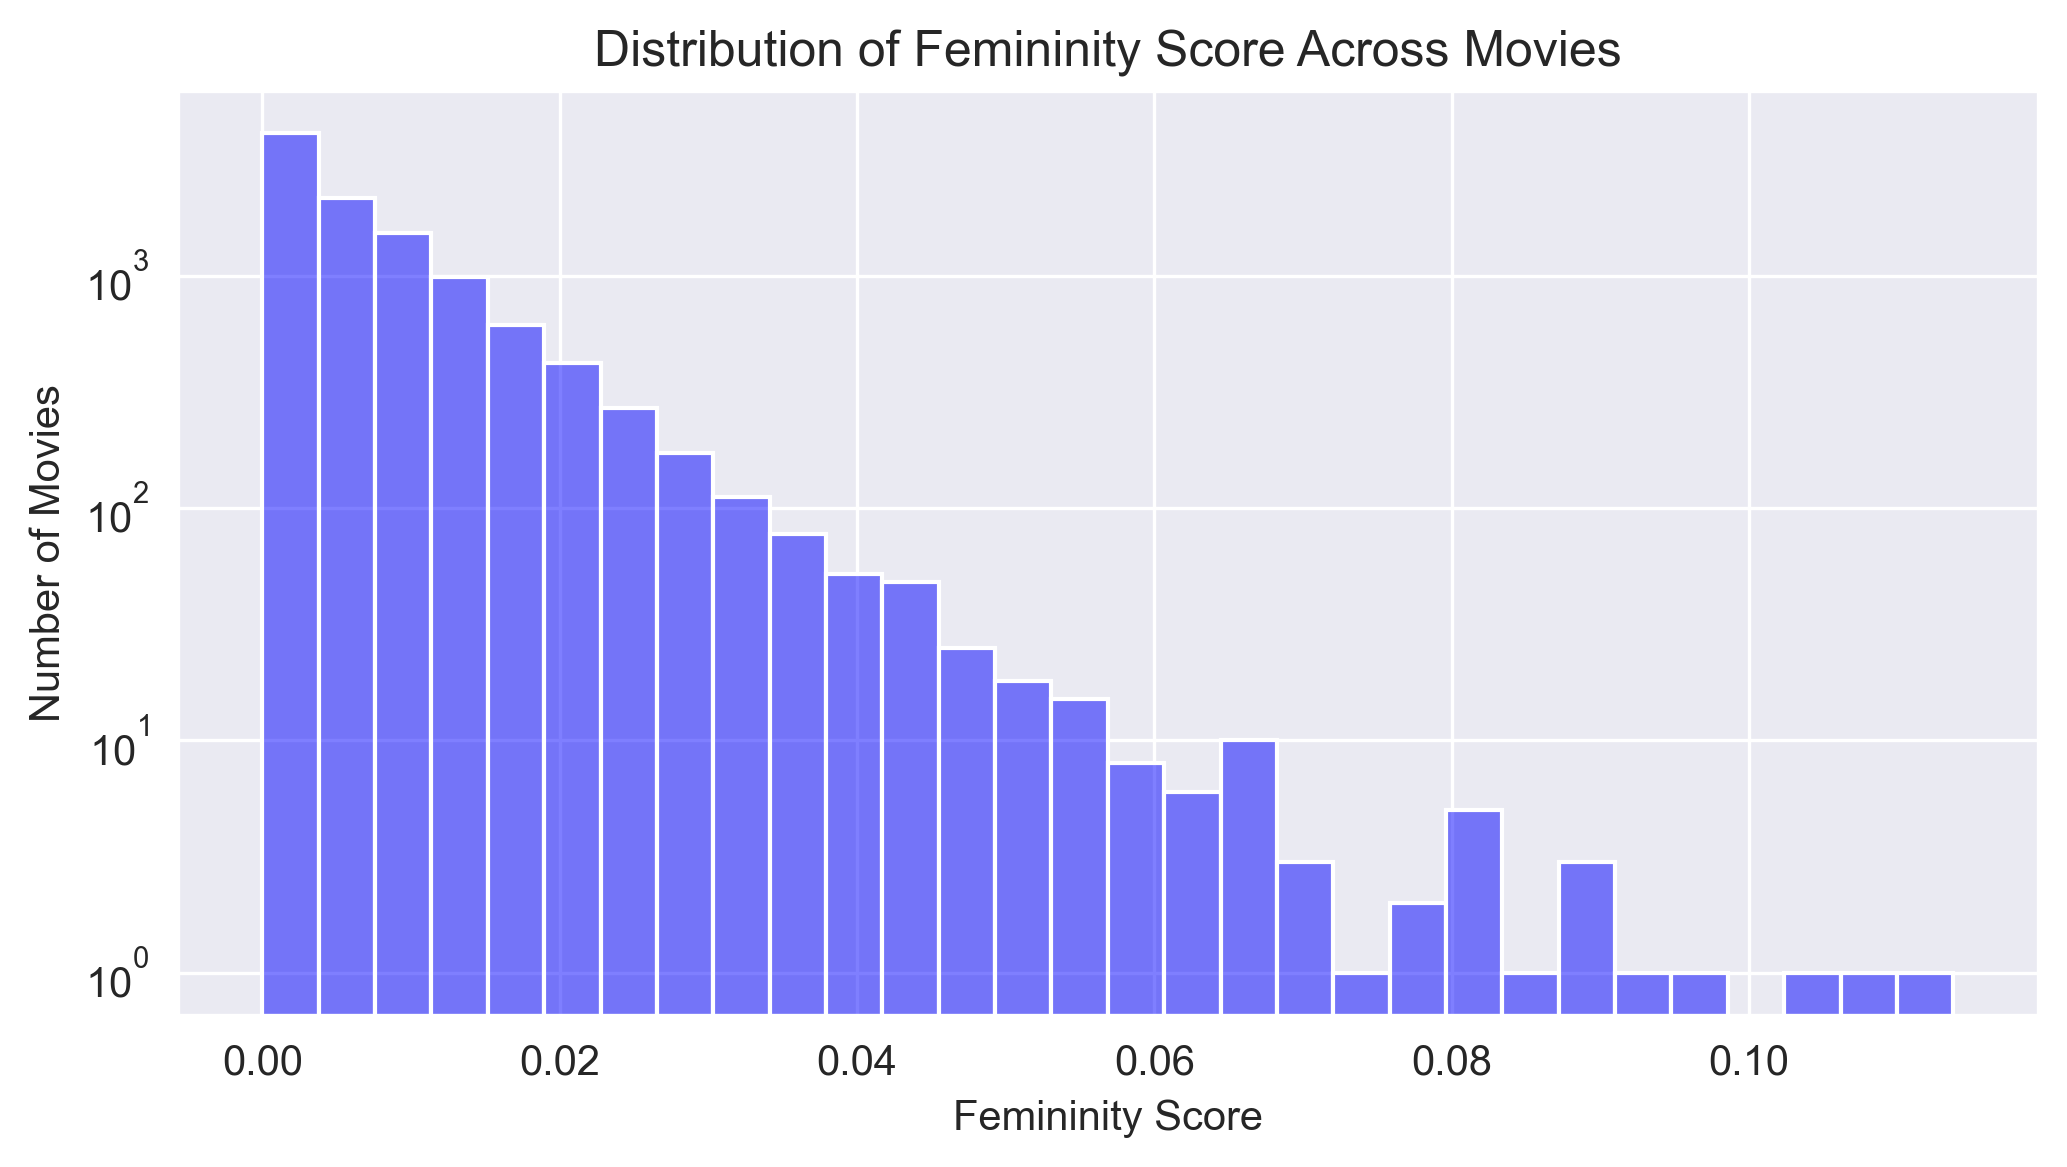

In [38]:
nlp_summaries = nlputils.nlp_compute_masculinity_score(nlp_summaries)
viz.visualize_masculinity_score_distribution(nlp_summaries)